In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "large"

In [4]:
# Parameters
fs_type = "fsv23"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 141
Categorical features: 9
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 213
Categorical Columns: 9


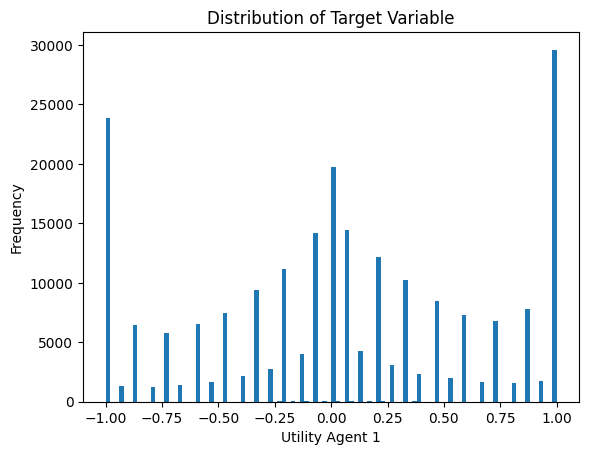

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.08
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.04
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.02
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.02 10000


In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters
    params = {
        'objective': "regression",
        'metric': 'rmse',
        'boosting': 'gbdt',
        ###################
        'num_leaves': 31,
        'max_depth': 12,
        'learning_rate': LEARNING_RATE,
        ###################
        'min_data_in_leaf': 100,
        'bagging_freq': 1,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.5,
        'verbose': -1,
        'seed': 2112,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=100),
            ]
        )
        
        # Get feature importance for this fold
        feat_importance = pd.DataFrame({
            'feature': numerical_cols + categorical_cols,
            f'importance_f{fold}': model.feature_importance(importance_type='gain')
        })
        feat_importance_dfs.append(feat_importance)
        
        # Plot feature importance
        lgb.plot_importance(model, figsize=(10, 8), importance_type='gain', max_num_features=50)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))
    
    return trained_models, oof, oof_scores, importance_df

Fold 1


[100]	valid_0's rmse: 0.500067


[200]	valid_0's rmse: 0.485004


[300]	valid_0's rmse: 0.476527


[400]	valid_0's rmse: 0.470777


[500]	valid_0's rmse: 0.465827


[600]	valid_0's rmse: 0.462738


[700]	valid_0's rmse: 0.459544


[800]	valid_0's rmse: 0.456611


[900]	valid_0's rmse: 0.454803


[1000]	valid_0's rmse: 0.452948


[1100]	valid_0's rmse: 0.451662


[1200]	valid_0's rmse: 0.450567


[1300]	valid_0's rmse: 0.449571


[1400]	valid_0's rmse: 0.448724


[1500]	valid_0's rmse: 0.448136


[1600]	valid_0's rmse: 0.447327


[1700]	valid_0's rmse: 0.446798


[1800]	valid_0's rmse: 0.446451


[1900]	valid_0's rmse: 0.446088


[2000]	valid_0's rmse: 0.44573


[2100]	valid_0's rmse: 0.445418


[2200]	valid_0's rmse: 0.444997


[2300]	valid_0's rmse: 0.444769


[2400]	valid_0's rmse: 0.444584


[2500]	valid_0's rmse: 0.444437


[2600]	valid_0's rmse: 0.444185


[2700]	valid_0's rmse: 0.44396


[2800]	valid_0's rmse: 0.443693


[2900]	valid_0's rmse: 0.443503


[3000]	valid_0's rmse: 0.443329


[3100]	valid_0's rmse: 0.443217


[3200]	valid_0's rmse: 0.44304


[3300]	valid_0's rmse: 0.442987


[3400]	valid_0's rmse: 0.442917


[3500]	valid_0's rmse: 0.442748


[3600]	valid_0's rmse: 0.442691


[3700]	valid_0's rmse: 0.442633


[3800]	valid_0's rmse: 0.442473


[3900]	valid_0's rmse: 0.442377


[4000]	valid_0's rmse: 0.44226


[4100]	valid_0's rmse: 0.442117


[4200]	valid_0's rmse: 0.44209


[4300]	valid_0's rmse: 0.441959


[4400]	valid_0's rmse: 0.441873


[4500]	valid_0's rmse: 0.44185


[4600]	valid_0's rmse: 0.441788


[4700]	valid_0's rmse: 0.441727


[4800]	valid_0's rmse: 0.441643


[4900]	valid_0's rmse: 0.441587


[5000]	valid_0's rmse: 0.441506


[5100]	valid_0's rmse: 0.441501


[5200]	valid_0's rmse: 0.441503


[5300]	valid_0's rmse: 0.441471


[5400]	valid_0's rmse: 0.441433


[5500]	valid_0's rmse: 0.441387


[5600]	valid_0's rmse: 0.441296


[5700]	valid_0's rmse: 0.441262


[5800]	valid_0's rmse: 0.441178


[5900]	valid_0's rmse: 0.441163


[6000]	valid_0's rmse: 0.441158


[6100]	valid_0's rmse: 0.441066


[6200]	valid_0's rmse: 0.441053


[6300]	valid_0's rmse: 0.441005


[6400]	valid_0's rmse: 0.441004


[6500]	valid_0's rmse: 0.440981


[6600]	valid_0's rmse: 0.440913


[6700]	valid_0's rmse: 0.440847


[6800]	valid_0's rmse: 0.440795


[6900]	valid_0's rmse: 0.440725


[7000]	valid_0's rmse: 0.440683


[7100]	valid_0's rmse: 0.4407


[7200]	valid_0's rmse: 0.440651


[7300]	valid_0's rmse: 0.440644


[7400]	valid_0's rmse: 0.440631


[7500]	valid_0's rmse: 0.44065


[7600]	valid_0's rmse: 0.440659


[7700]	valid_0's rmse: 0.440676


[7800]	valid_0's rmse: 0.440676


[7900]	valid_0's rmse: 0.440642


[8000]	valid_0's rmse: 0.440668


[8100]	valid_0's rmse: 0.44066


[8200]	valid_0's rmse: 0.440678


[8300]	valid_0's rmse: 0.440718


[8400]	valid_0's rmse: 0.440717


[8500]	valid_0's rmse: 0.440739


[8600]	valid_0's rmse: 0.440802


[8700]	valid_0's rmse: 0.44081


[8800]	valid_0's rmse: 0.440777


[8900]	valid_0's rmse: 0.440779


[9000]	valid_0's rmse: 0.440755


[9100]	valid_0's rmse: 0.440735


[9200]	valid_0's rmse: 0.440724


[9300]	valid_0's rmse: 0.440749


[9400]	valid_0's rmse: 0.44077


[9500]	valid_0's rmse: 0.440741


[9600]	valid_0's rmse: 0.440803


[9700]	valid_0's rmse: 0.440811


[9800]	valid_0's rmse: 0.440808


[9900]	valid_0's rmse: 0.440845


[10000]	valid_0's rmse: 0.440776


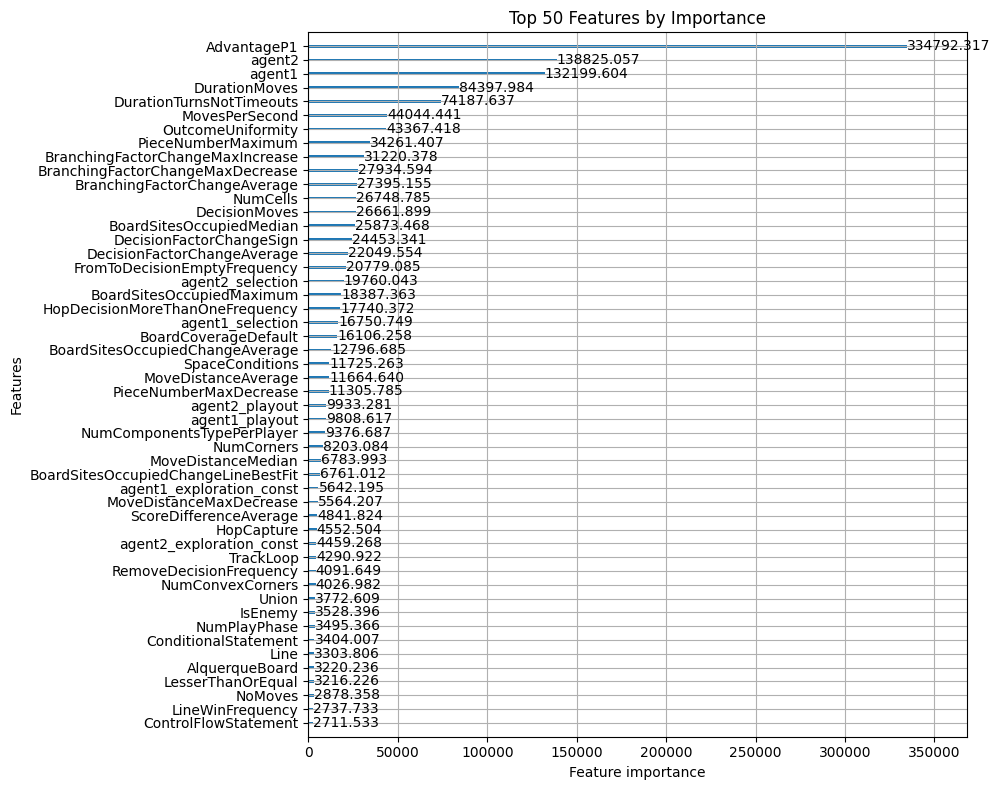

Fold 1 - RMSE: 0.4402436140644098
Fold 2


[100]	valid_0's rmse: 0.514429


[200]	valid_0's rmse: 0.494166


[300]	valid_0's rmse: 0.484279


[400]	valid_0's rmse: 0.479259


[500]	valid_0's rmse: 0.474006


[600]	valid_0's rmse: 0.470733


[700]	valid_0's rmse: 0.468139


[800]	valid_0's rmse: 0.465886


[900]	valid_0's rmse: 0.463616


[1000]	valid_0's rmse: 0.462394


[1100]	valid_0's rmse: 0.461396


[1200]	valid_0's rmse: 0.460348


[1300]	valid_0's rmse: 0.459382


[1400]	valid_0's rmse: 0.458652


[1500]	valid_0's rmse: 0.457895


[1600]	valid_0's rmse: 0.45701


[1700]	valid_0's rmse: 0.456297


[1800]	valid_0's rmse: 0.455821


[1900]	valid_0's rmse: 0.455321


[2000]	valid_0's rmse: 0.454798


[2100]	valid_0's rmse: 0.454367


[2200]	valid_0's rmse: 0.454045


[2300]	valid_0's rmse: 0.453561


[2400]	valid_0's rmse: 0.45332


[2500]	valid_0's rmse: 0.453082


[2600]	valid_0's rmse: 0.452717


[2700]	valid_0's rmse: 0.452451


[2800]	valid_0's rmse: 0.452265


[2900]	valid_0's rmse: 0.451962


[3000]	valid_0's rmse: 0.451636


[3100]	valid_0's rmse: 0.451507


[3200]	valid_0's rmse: 0.451214


[3300]	valid_0's rmse: 0.451059


[3400]	valid_0's rmse: 0.45085


[3500]	valid_0's rmse: 0.450649


[3600]	valid_0's rmse: 0.450432


[3700]	valid_0's rmse: 0.450234


[3800]	valid_0's rmse: 0.450024


[3900]	valid_0's rmse: 0.449868


[4000]	valid_0's rmse: 0.449703


[4100]	valid_0's rmse: 0.449631


[4200]	valid_0's rmse: 0.449502


[4300]	valid_0's rmse: 0.449346


[4400]	valid_0's rmse: 0.449253


[4500]	valid_0's rmse: 0.449125


[4600]	valid_0's rmse: 0.448948


[4700]	valid_0's rmse: 0.448868


[4800]	valid_0's rmse: 0.448821


[4900]	valid_0's rmse: 0.448631


[5000]	valid_0's rmse: 0.448514


[5100]	valid_0's rmse: 0.448407


[5200]	valid_0's rmse: 0.448331


[5300]	valid_0's rmse: 0.448201


[5400]	valid_0's rmse: 0.44814


[5500]	valid_0's rmse: 0.44805


[5600]	valid_0's rmse: 0.448008


[5700]	valid_0's rmse: 0.447968


[5800]	valid_0's rmse: 0.44789


[5900]	valid_0's rmse: 0.44789


[6000]	valid_0's rmse: 0.447907


[6100]	valid_0's rmse: 0.447844


[6200]	valid_0's rmse: 0.447703


[6300]	valid_0's rmse: 0.447647


[6400]	valid_0's rmse: 0.447613


[6500]	valid_0's rmse: 0.447561


[6600]	valid_0's rmse: 0.447452


[6700]	valid_0's rmse: 0.447405


[6800]	valid_0's rmse: 0.447345


[6900]	valid_0's rmse: 0.44738


[7000]	valid_0's rmse: 0.447393


[7100]	valid_0's rmse: 0.44735


[7200]	valid_0's rmse: 0.447323


[7300]	valid_0's rmse: 0.447297


[7400]	valid_0's rmse: 0.44717


[7500]	valid_0's rmse: 0.447184


[7600]	valid_0's rmse: 0.447091


[7700]	valid_0's rmse: 0.446984


[7800]	valid_0's rmse: 0.446961


[7900]	valid_0's rmse: 0.446948


[8000]	valid_0's rmse: 0.446927


[8100]	valid_0's rmse: 0.446905


[8200]	valid_0's rmse: 0.446886


[8300]	valid_0's rmse: 0.44689


[8400]	valid_0's rmse: 0.446826


[8500]	valid_0's rmse: 0.44678


[8600]	valid_0's rmse: 0.446725


[8700]	valid_0's rmse: 0.446628


[8800]	valid_0's rmse: 0.44665


[8900]	valid_0's rmse: 0.446606


[9000]	valid_0's rmse: 0.446577


[9100]	valid_0's rmse: 0.446525


[9200]	valid_0's rmse: 0.446532


[9300]	valid_0's rmse: 0.446485


[9400]	valid_0's rmse: 0.446478


[9500]	valid_0's rmse: 0.446439


[9600]	valid_0's rmse: 0.446386


[9700]	valid_0's rmse: 0.446316


[9800]	valid_0's rmse: 0.44629


[9900]	valid_0's rmse: 0.446235


[10000]	valid_0's rmse: 0.446257


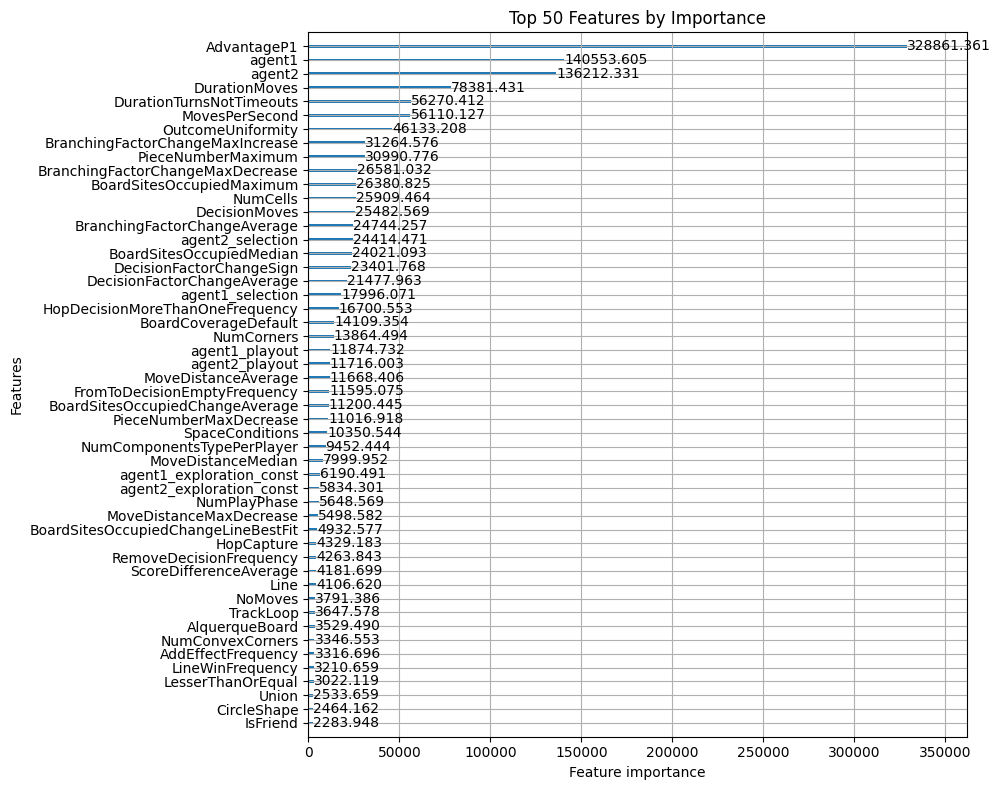

Fold 2 - RMSE: 0.4458377971988968
Fold 3


[100]	valid_0's rmse: 0.511032


[200]	valid_0's rmse: 0.483835


[300]	valid_0's rmse: 0.470725


[400]	valid_0's rmse: 0.464219


[500]	valid_0's rmse: 0.460091


[600]	valid_0's rmse: 0.45626


[700]	valid_0's rmse: 0.454084


[800]	valid_0's rmse: 0.451917


[900]	valid_0's rmse: 0.449927


[1000]	valid_0's rmse: 0.448217


[1100]	valid_0's rmse: 0.446515


[1200]	valid_0's rmse: 0.445081


[1300]	valid_0's rmse: 0.444251


[1400]	valid_0's rmse: 0.443206


[1500]	valid_0's rmse: 0.442271


[1600]	valid_0's rmse: 0.441347


[1700]	valid_0's rmse: 0.440618


[1800]	valid_0's rmse: 0.440049


[1900]	valid_0's rmse: 0.439548


[2000]	valid_0's rmse: 0.439009


[2100]	valid_0's rmse: 0.438593


[2200]	valid_0's rmse: 0.438232


[2300]	valid_0's rmse: 0.43779


[2400]	valid_0's rmse: 0.437387


[2500]	valid_0's rmse: 0.436955


[2600]	valid_0's rmse: 0.43697


[2700]	valid_0's rmse: 0.436658


[2800]	valid_0's rmse: 0.436401


[2900]	valid_0's rmse: 0.436183


[3000]	valid_0's rmse: 0.435906


[3100]	valid_0's rmse: 0.435551


[3200]	valid_0's rmse: 0.435397


[3300]	valid_0's rmse: 0.435129


[3400]	valid_0's rmse: 0.435075


[3500]	valid_0's rmse: 0.434698


[3600]	valid_0's rmse: 0.434544


[3700]	valid_0's rmse: 0.434365


[3800]	valid_0's rmse: 0.434203


[3900]	valid_0's rmse: 0.434053


[4000]	valid_0's rmse: 0.433956


[4100]	valid_0's rmse: 0.433835


[4200]	valid_0's rmse: 0.433793


[4300]	valid_0's rmse: 0.433634


[4400]	valid_0's rmse: 0.433436


[4500]	valid_0's rmse: 0.433309


[4600]	valid_0's rmse: 0.433186


[4700]	valid_0's rmse: 0.433066


[4800]	valid_0's rmse: 0.432974


[4900]	valid_0's rmse: 0.432882


[5000]	valid_0's rmse: 0.432804


[5100]	valid_0's rmse: 0.432678


[5200]	valid_0's rmse: 0.432646


[5300]	valid_0's rmse: 0.432573


[5400]	valid_0's rmse: 0.432556


[5500]	valid_0's rmse: 0.432611


[5600]	valid_0's rmse: 0.432559


[5700]	valid_0's rmse: 0.432523


[5800]	valid_0's rmse: 0.432437


[5900]	valid_0's rmse: 0.432376


[6000]	valid_0's rmse: 0.432369


[6100]	valid_0's rmse: 0.432297


[6200]	valid_0's rmse: 0.432232


[6300]	valid_0's rmse: 0.432108


[6400]	valid_0's rmse: 0.432138


[6500]	valid_0's rmse: 0.432132


[6600]	valid_0's rmse: 0.432131


[6700]	valid_0's rmse: 0.432082


[6800]	valid_0's rmse: 0.432022


[6900]	valid_0's rmse: 0.431914


[7000]	valid_0's rmse: 0.431889


[7100]	valid_0's rmse: 0.43184


[7200]	valid_0's rmse: 0.431829


[7300]	valid_0's rmse: 0.431822


[7400]	valid_0's rmse: 0.431814


[7500]	valid_0's rmse: 0.431756


[7600]	valid_0's rmse: 0.431725


[7700]	valid_0's rmse: 0.431696


[7800]	valid_0's rmse: 0.431712


[7900]	valid_0's rmse: 0.431689


[8000]	valid_0's rmse: 0.431711


[8100]	valid_0's rmse: 0.431742


[8200]	valid_0's rmse: 0.431714


[8300]	valid_0's rmse: 0.431651


[8400]	valid_0's rmse: 0.431629


[8500]	valid_0's rmse: 0.431594


[8600]	valid_0's rmse: 0.431568


[8700]	valid_0's rmse: 0.43149


[8800]	valid_0's rmse: 0.431484


[8900]	valid_0's rmse: 0.431487


[9000]	valid_0's rmse: 0.431462


[9100]	valid_0's rmse: 0.43146


[9200]	valid_0's rmse: 0.431468


[9300]	valid_0's rmse: 0.431455


[9400]	valid_0's rmse: 0.431446


[9500]	valid_0's rmse: 0.431381


[9600]	valid_0's rmse: 0.431401


[9700]	valid_0's rmse: 0.431424


[9800]	valid_0's rmse: 0.431418


[9900]	valid_0's rmse: 0.431411


[10000]	valid_0's rmse: 0.431393


Fold 3 - RMSE: 0.43073990756917546
Fold 4


[100]	valid_0's rmse: 0.512654


[200]	valid_0's rmse: 0.490757


[300]	valid_0's rmse: 0.480011


[400]	valid_0's rmse: 0.472535


[500]	valid_0's rmse: 0.466806


[600]	valid_0's rmse: 0.462355


[700]	valid_0's rmse: 0.459469


[800]	valid_0's rmse: 0.456183


[900]	valid_0's rmse: 0.454019


[1000]	valid_0's rmse: 0.451835


[1100]	valid_0's rmse: 0.45008


[1200]	valid_0's rmse: 0.448853


[1300]	valid_0's rmse: 0.447652


[1400]	valid_0's rmse: 0.446638


[1500]	valid_0's rmse: 0.445543


[1600]	valid_0's rmse: 0.444634


[1700]	valid_0's rmse: 0.443661


[1800]	valid_0's rmse: 0.442786


[1900]	valid_0's rmse: 0.442063


[2000]	valid_0's rmse: 0.441389


[2100]	valid_0's rmse: 0.440927


[2200]	valid_0's rmse: 0.440292


[2300]	valid_0's rmse: 0.439943


[2400]	valid_0's rmse: 0.439527


[2500]	valid_0's rmse: 0.439106


[2600]	valid_0's rmse: 0.438564


[2700]	valid_0's rmse: 0.438288


[2800]	valid_0's rmse: 0.437788


[2900]	valid_0's rmse: 0.437549


[3000]	valid_0's rmse: 0.437141


[3100]	valid_0's rmse: 0.436811


[3200]	valid_0's rmse: 0.436574


[3300]	valid_0's rmse: 0.436501


[3400]	valid_0's rmse: 0.43626


[3500]	valid_0's rmse: 0.436035


[3600]	valid_0's rmse: 0.43581


[3700]	valid_0's rmse: 0.435558


[3800]	valid_0's rmse: 0.43528


[3900]	valid_0's rmse: 0.435095


[4000]	valid_0's rmse: 0.434904


[4100]	valid_0's rmse: 0.434673


[4200]	valid_0's rmse: 0.43462


[4300]	valid_0's rmse: 0.434394


[4400]	valid_0's rmse: 0.434202


[4500]	valid_0's rmse: 0.434025


[4600]	valid_0's rmse: 0.433905


[4700]	valid_0's rmse: 0.433862


[4800]	valid_0's rmse: 0.433733


[4900]	valid_0's rmse: 0.43367


[5000]	valid_0's rmse: 0.433556


[5100]	valid_0's rmse: 0.433446


[5200]	valid_0's rmse: 0.433289


[5300]	valid_0's rmse: 0.433188


[5400]	valid_0's rmse: 0.43313


[5500]	valid_0's rmse: 0.432999


[5600]	valid_0's rmse: 0.432887


[5700]	valid_0's rmse: 0.43276


[5800]	valid_0's rmse: 0.432723


[5900]	valid_0's rmse: 0.432698


[6000]	valid_0's rmse: 0.432627


[6100]	valid_0's rmse: 0.432532


[6200]	valid_0's rmse: 0.432449


[6300]	valid_0's rmse: 0.432393


[6400]	valid_0's rmse: 0.432313


[6500]	valid_0's rmse: 0.43229


[6600]	valid_0's rmse: 0.432294


[6700]	valid_0's rmse: 0.432233


[6800]	valid_0's rmse: 0.432192


[6900]	valid_0's rmse: 0.432155


[7000]	valid_0's rmse: 0.432019


[7100]	valid_0's rmse: 0.43192


[7200]	valid_0's rmse: 0.431883


[7300]	valid_0's rmse: 0.431833


[7400]	valid_0's rmse: 0.431744


[7500]	valid_0's rmse: 0.431711


[7600]	valid_0's rmse: 0.43162


[7700]	valid_0's rmse: 0.431634


[7800]	valid_0's rmse: 0.431575


[7900]	valid_0's rmse: 0.431538


[8000]	valid_0's rmse: 0.431487


[8100]	valid_0's rmse: 0.43148


[8200]	valid_0's rmse: 0.431493


[8300]	valid_0's rmse: 0.431481


[8400]	valid_0's rmse: 0.431468


[8500]	valid_0's rmse: 0.431434


[8600]	valid_0's rmse: 0.431401


[8700]	valid_0's rmse: 0.431409


[8800]	valid_0's rmse: 0.431355


[8900]	valid_0's rmse: 0.431368


[9000]	valid_0's rmse: 0.431346


[9100]	valid_0's rmse: 0.43131


[9200]	valid_0's rmse: 0.431275


[9300]	valid_0's rmse: 0.431245


[9400]	valid_0's rmse: 0.431249


[9500]	valid_0's rmse: 0.431169


[9600]	valid_0's rmse: 0.431163


[9700]	valid_0's rmse: 0.431136


[9800]	valid_0's rmse: 0.43109


[9900]	valid_0's rmse: 0.431044


[10000]	valid_0's rmse: 0.431012


Fold 4 - RMSE: 0.4304593727220183
Fold 5


[100]	valid_0's rmse: 0.489296


[200]	valid_0's rmse: 0.466193


[300]	valid_0's rmse: 0.454646


[400]	valid_0's rmse: 0.447078


[500]	valid_0's rmse: 0.440657


[600]	valid_0's rmse: 0.436122


[700]	valid_0's rmse: 0.432722


[800]	valid_0's rmse: 0.429746


[900]	valid_0's rmse: 0.427254


[1000]	valid_0's rmse: 0.425737


[1100]	valid_0's rmse: 0.424059


[1200]	valid_0's rmse: 0.422682


[1300]	valid_0's rmse: 0.421499


[1400]	valid_0's rmse: 0.420449


[1500]	valid_0's rmse: 0.419301


[1600]	valid_0's rmse: 0.41866


[1700]	valid_0's rmse: 0.417784


[1800]	valid_0's rmse: 0.417154


[1900]	valid_0's rmse: 0.416507


[2000]	valid_0's rmse: 0.416188


[2100]	valid_0's rmse: 0.415594


[2200]	valid_0's rmse: 0.414877


[2300]	valid_0's rmse: 0.414397


[2400]	valid_0's rmse: 0.414006


[2500]	valid_0's rmse: 0.413703


[2600]	valid_0's rmse: 0.413331


[2700]	valid_0's rmse: 0.412975


[2800]	valid_0's rmse: 0.412594


[2900]	valid_0's rmse: 0.412201


[3000]	valid_0's rmse: 0.411948


[3100]	valid_0's rmse: 0.411902


[3200]	valid_0's rmse: 0.411655


[3300]	valid_0's rmse: 0.411398


[3400]	valid_0's rmse: 0.411182


[3500]	valid_0's rmse: 0.411023


[3600]	valid_0's rmse: 0.410879


[3700]	valid_0's rmse: 0.410593


[3800]	valid_0's rmse: 0.41048


[3900]	valid_0's rmse: 0.410256


[4000]	valid_0's rmse: 0.41014


[4100]	valid_0's rmse: 0.409935


[4200]	valid_0's rmse: 0.409621


[4300]	valid_0's rmse: 0.409468


[4400]	valid_0's rmse: 0.40933


[4500]	valid_0's rmse: 0.409255


[4600]	valid_0's rmse: 0.40909


[4700]	valid_0's rmse: 0.408926


[4800]	valid_0's rmse: 0.408863


[4900]	valid_0's rmse: 0.408724


[5000]	valid_0's rmse: 0.408637


[5100]	valid_0's rmse: 0.408504


[5200]	valid_0's rmse: 0.408446


[5300]	valid_0's rmse: 0.408421


[5400]	valid_0's rmse: 0.408419


[5500]	valid_0's rmse: 0.408365


[5600]	valid_0's rmse: 0.408299


[5700]	valid_0's rmse: 0.408344


[5800]	valid_0's rmse: 0.408356


[5900]	valid_0's rmse: 0.408351


[6000]	valid_0's rmse: 0.408315


[6100]	valid_0's rmse: 0.408262


[6200]	valid_0's rmse: 0.408172


[6300]	valid_0's rmse: 0.408134


[6400]	valid_0's rmse: 0.408158


[6500]	valid_0's rmse: 0.408053


[6600]	valid_0's rmse: 0.40801


[6700]	valid_0's rmse: 0.407904


[6800]	valid_0's rmse: 0.407853


[6900]	valid_0's rmse: 0.407822


[7000]	valid_0's rmse: 0.407774


[7100]	valid_0's rmse: 0.407732


[7200]	valid_0's rmse: 0.407646


[7300]	valid_0's rmse: 0.407565


[7400]	valid_0's rmse: 0.407572


[7500]	valid_0's rmse: 0.407565


[7600]	valid_0's rmse: 0.407584


[7700]	valid_0's rmse: 0.407569


[7800]	valid_0's rmse: 0.407566


[7900]	valid_0's rmse: 0.407513


[8000]	valid_0's rmse: 0.407455


[8100]	valid_0's rmse: 0.407389


[8200]	valid_0's rmse: 0.407393


[8300]	valid_0's rmse: 0.407384


[8400]	valid_0's rmse: 0.407392


[8500]	valid_0's rmse: 0.407339


[8600]	valid_0's rmse: 0.407257


[8700]	valid_0's rmse: 0.4072


[8800]	valid_0's rmse: 0.407154


[8900]	valid_0's rmse: 0.407172


[9000]	valid_0's rmse: 0.40718


[9100]	valid_0's rmse: 0.407165


[9200]	valid_0's rmse: 0.407184


[9300]	valid_0's rmse: 0.407214


[9400]	valid_0's rmse: 0.407194


[9500]	valid_0's rmse: 0.407185


[9600]	valid_0's rmse: 0.407224


[9700]	valid_0's rmse: 0.407164


[9800]	valid_0's rmse: 0.40718


[9900]	valid_0's rmse: 0.40715


[10000]	valid_0's rmse: 0.407161


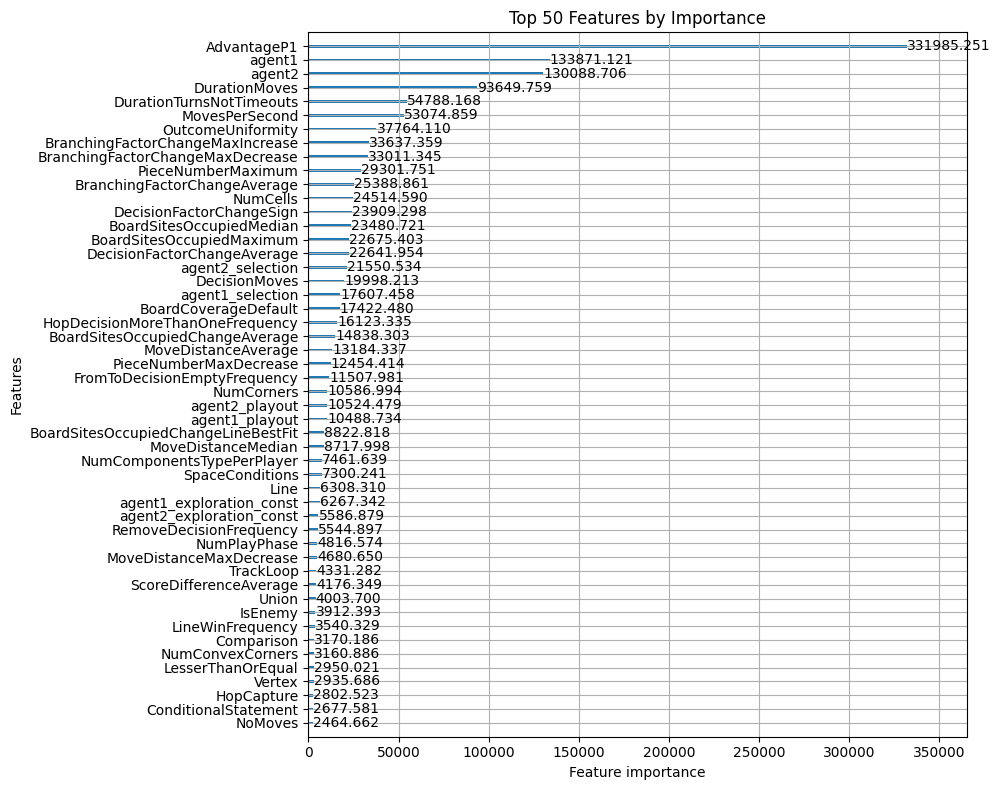

Fold 5 - RMSE: 0.4067940647839461
List of oof scores: [0.4402436140644098, 0.4458377971988968, 0.43073990756917546, 0.4304593727220183, 0.4067940647839461]
Average oof score: 0.4308149512676893


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv1.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.482844


[200]	valid_0's rmse: 0.464026


[300]	valid_0's rmse: 0.454609


[400]	valid_0's rmse: 0.449309


[500]	valid_0's rmse: 0.445801


[600]	valid_0's rmse: 0.443014


[700]	valid_0's rmse: 0.440605


[800]	valid_0's rmse: 0.438448


[900]	valid_0's rmse: 0.436778


[1000]	valid_0's rmse: 0.43525


[1100]	valid_0's rmse: 0.433915


[1200]	valid_0's rmse: 0.433006


[1300]	valid_0's rmse: 0.43216


[1400]	valid_0's rmse: 0.431499


[1500]	valid_0's rmse: 0.430908


[1600]	valid_0's rmse: 0.430244


[1700]	valid_0's rmse: 0.429607


[1800]	valid_0's rmse: 0.429122


[1900]	valid_0's rmse: 0.428688


[2000]	valid_0's rmse: 0.428259


[2100]	valid_0's rmse: 0.427799


[2200]	valid_0's rmse: 0.427437


[2300]	valid_0's rmse: 0.427206


[2400]	valid_0's rmse: 0.427146


[2500]	valid_0's rmse: 0.426809


[2600]	valid_0's rmse: 0.426539


[2700]	valid_0's rmse: 0.426257


[2800]	valid_0's rmse: 0.426083


[2900]	valid_0's rmse: 0.425911


[3000]	valid_0's rmse: 0.425683


[3100]	valid_0's rmse: 0.425447


[3200]	valid_0's rmse: 0.425295


[3300]	valid_0's rmse: 0.425144


[3400]	valid_0's rmse: 0.425066


[3500]	valid_0's rmse: 0.424929


[3600]	valid_0's rmse: 0.42483


[3700]	valid_0's rmse: 0.424586


[3800]	valid_0's rmse: 0.424437


[3900]	valid_0's rmse: 0.424193


[4000]	valid_0's rmse: 0.424124


[4100]	valid_0's rmse: 0.424029


[4200]	valid_0's rmse: 0.42392


[4300]	valid_0's rmse: 0.423845


[4400]	valid_0's rmse: 0.423732


[4500]	valid_0's rmse: 0.42365


[4600]	valid_0's rmse: 0.423528


[4700]	valid_0's rmse: 0.423418


[4800]	valid_0's rmse: 0.423427


[4900]	valid_0's rmse: 0.423342


[5000]	valid_0's rmse: 0.423236


[5100]	valid_0's rmse: 0.423284


[5200]	valid_0's rmse: 0.423269


[5300]	valid_0's rmse: 0.423134


[5400]	valid_0's rmse: 0.423031


[5500]	valid_0's rmse: 0.422974


[5600]	valid_0's rmse: 0.422863


[5700]	valid_0's rmse: 0.422818


[5800]	valid_0's rmse: 0.422835


[5900]	valid_0's rmse: 0.422784


[6000]	valid_0's rmse: 0.42278


[6100]	valid_0's rmse: 0.422667


[6200]	valid_0's rmse: 0.422601


[6300]	valid_0's rmse: 0.422552


[6400]	valid_0's rmse: 0.422548


[6500]	valid_0's rmse: 0.422494


[6600]	valid_0's rmse: 0.422405


[6700]	valid_0's rmse: 0.422336


[6800]	valid_0's rmse: 0.422269


[6900]	valid_0's rmse: 0.422223


[7000]	valid_0's rmse: 0.422125


[7100]	valid_0's rmse: 0.422067


[7200]	valid_0's rmse: 0.421991


[7300]	valid_0's rmse: 0.421993


[7400]	valid_0's rmse: 0.421946


[7500]	valid_0's rmse: 0.421847


[7600]	valid_0's rmse: 0.421822


[7700]	valid_0's rmse: 0.421807


[7800]	valid_0's rmse: 0.421781


[7900]	valid_0's rmse: 0.421778


[8000]	valid_0's rmse: 0.42174


[8100]	valid_0's rmse: 0.421678


[8200]	valid_0's rmse: 0.421609


[8300]	valid_0's rmse: 0.421602


[8400]	valid_0's rmse: 0.421577


[8500]	valid_0's rmse: 0.421569


[8600]	valid_0's rmse: 0.421521


[8700]	valid_0's rmse: 0.421465


[8800]	valid_0's rmse: 0.421397


[8900]	valid_0's rmse: 0.421399


[9000]	valid_0's rmse: 0.421411


[9100]	valid_0's rmse: 0.421376


[9200]	valid_0's rmse: 0.421378


[9300]	valid_0's rmse: 0.421299


[9400]	valid_0's rmse: 0.421314


[9500]	valid_0's rmse: 0.421276


[9600]	valid_0's rmse: 0.421296


[9700]	valid_0's rmse: 0.42125


[9800]	valid_0's rmse: 0.42118


[9900]	valid_0's rmse: 0.421153


[10000]	valid_0's rmse: 0.421146


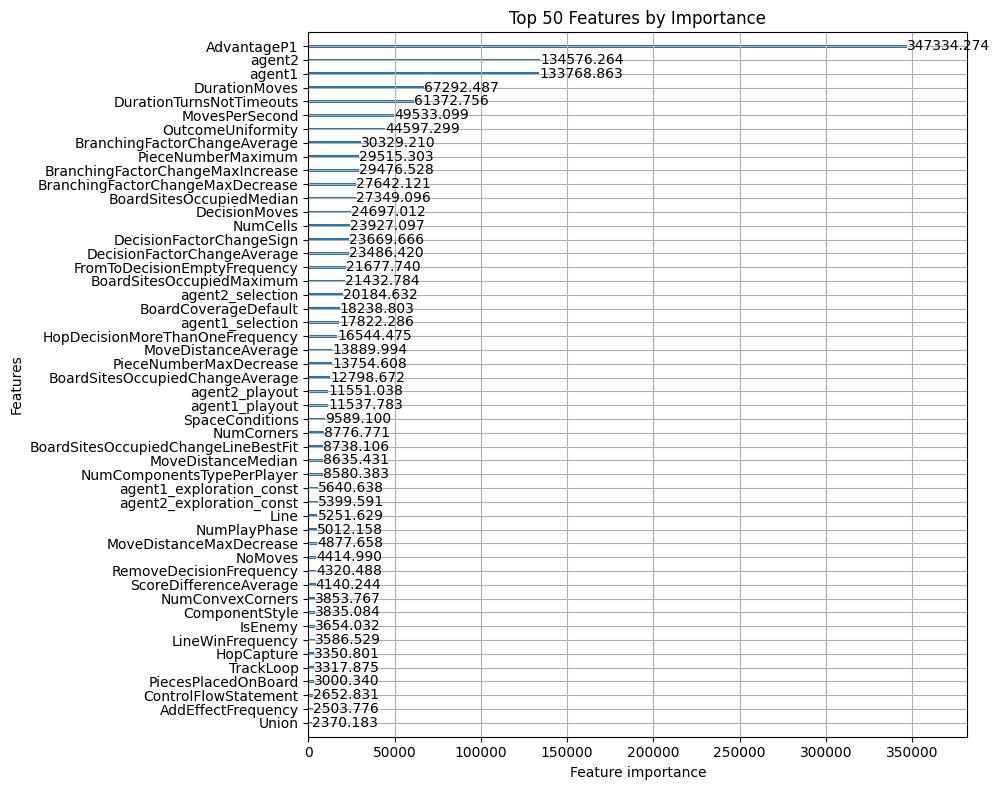

Fold 1 - RMSE: 0.42067122161304343
Fold 2


[100]	valid_0's rmse: 0.466335


[200]	valid_0's rmse: 0.445077


[300]	valid_0's rmse: 0.436937


[400]	valid_0's rmse: 0.431231


[500]	valid_0's rmse: 0.428324


[600]	valid_0's rmse: 0.426067


[700]	valid_0's rmse: 0.424587


[800]	valid_0's rmse: 0.423461


[900]	valid_0's rmse: 0.42192


[1000]	valid_0's rmse: 0.420847


[1100]	valid_0's rmse: 0.419725


[1200]	valid_0's rmse: 0.418976


[1300]	valid_0's rmse: 0.418222


[1400]	valid_0's rmse: 0.417651


[1500]	valid_0's rmse: 0.416918


[1600]	valid_0's rmse: 0.416411


[1700]	valid_0's rmse: 0.415977


[1800]	valid_0's rmse: 0.415573


[1900]	valid_0's rmse: 0.415132


[2000]	valid_0's rmse: 0.41469


[2100]	valid_0's rmse: 0.414432


[2200]	valid_0's rmse: 0.414192


[2300]	valid_0's rmse: 0.413877


[2400]	valid_0's rmse: 0.413619


[2500]	valid_0's rmse: 0.413486


[2600]	valid_0's rmse: 0.413368


[2700]	valid_0's rmse: 0.41324


[2800]	valid_0's rmse: 0.413076


[2900]	valid_0's rmse: 0.412911


[3000]	valid_0's rmse: 0.412778


[3100]	valid_0's rmse: 0.412662


[3200]	valid_0's rmse: 0.412535


[3300]	valid_0's rmse: 0.412394


[3400]	valid_0's rmse: 0.412344


[3500]	valid_0's rmse: 0.412263


[3600]	valid_0's rmse: 0.412142


[3700]	valid_0's rmse: 0.412096


[3800]	valid_0's rmse: 0.412046


[3900]	valid_0's rmse: 0.412044


[4000]	valid_0's rmse: 0.412054


[4100]	valid_0's rmse: 0.412072


[4200]	valid_0's rmse: 0.412061


[4300]	valid_0's rmse: 0.411917


[4400]	valid_0's rmse: 0.411931


[4500]	valid_0's rmse: 0.411835


[4600]	valid_0's rmse: 0.411795


[4700]	valid_0's rmse: 0.41175


[4800]	valid_0's rmse: 0.411702


[4900]	valid_0's rmse: 0.411648


[5000]	valid_0's rmse: 0.411557


[5100]	valid_0's rmse: 0.411522


[5200]	valid_0's rmse: 0.411476


[5300]	valid_0's rmse: 0.411473


[5400]	valid_0's rmse: 0.41145


[5500]	valid_0's rmse: 0.411485


[5600]	valid_0's rmse: 0.411424


[5700]	valid_0's rmse: 0.411418


[5800]	valid_0's rmse: 0.41141


[5900]	valid_0's rmse: 0.411371


[6000]	valid_0's rmse: 0.411366


[6100]	valid_0's rmse: 0.41135


[6200]	valid_0's rmse: 0.411341


[6300]	valid_0's rmse: 0.411349


[6400]	valid_0's rmse: 0.411304


[6500]	valid_0's rmse: 0.411213


[6600]	valid_0's rmse: 0.41116


[6700]	valid_0's rmse: 0.411142


[6800]	valid_0's rmse: 0.411142


[6900]	valid_0's rmse: 0.411134


[7000]	valid_0's rmse: 0.411087


[7100]	valid_0's rmse: 0.411095


[7200]	valid_0's rmse: 0.411105


[7300]	valid_0's rmse: 0.41114


[7400]	valid_0's rmse: 0.411187


[7500]	valid_0's rmse: 0.411186


[7600]	valid_0's rmse: 0.411193


[7700]	valid_0's rmse: 0.411178


[7800]	valid_0's rmse: 0.411123


[7900]	valid_0's rmse: 0.411176


[8000]	valid_0's rmse: 0.411248


[8100]	valid_0's rmse: 0.411207


[8200]	valid_0's rmse: 0.411213


[8300]	valid_0's rmse: 0.41126


[8400]	valid_0's rmse: 0.411223


[8500]	valid_0's rmse: 0.411241


[8600]	valid_0's rmse: 0.411295


[8700]	valid_0's rmse: 0.411316


[8800]	valid_0's rmse: 0.411352


[8900]	valid_0's rmse: 0.411357


[9000]	valid_0's rmse: 0.411387


[9100]	valid_0's rmse: 0.411404


[9200]	valid_0's rmse: 0.411401


[9300]	valid_0's rmse: 0.411441


[9400]	valid_0's rmse: 0.411396


[9500]	valid_0's rmse: 0.411469


[9600]	valid_0's rmse: 0.411473


[9700]	valid_0's rmse: 0.411499


[9800]	valid_0's rmse: 0.411463


[9900]	valid_0's rmse: 0.411481


[10000]	valid_0's rmse: 0.411475


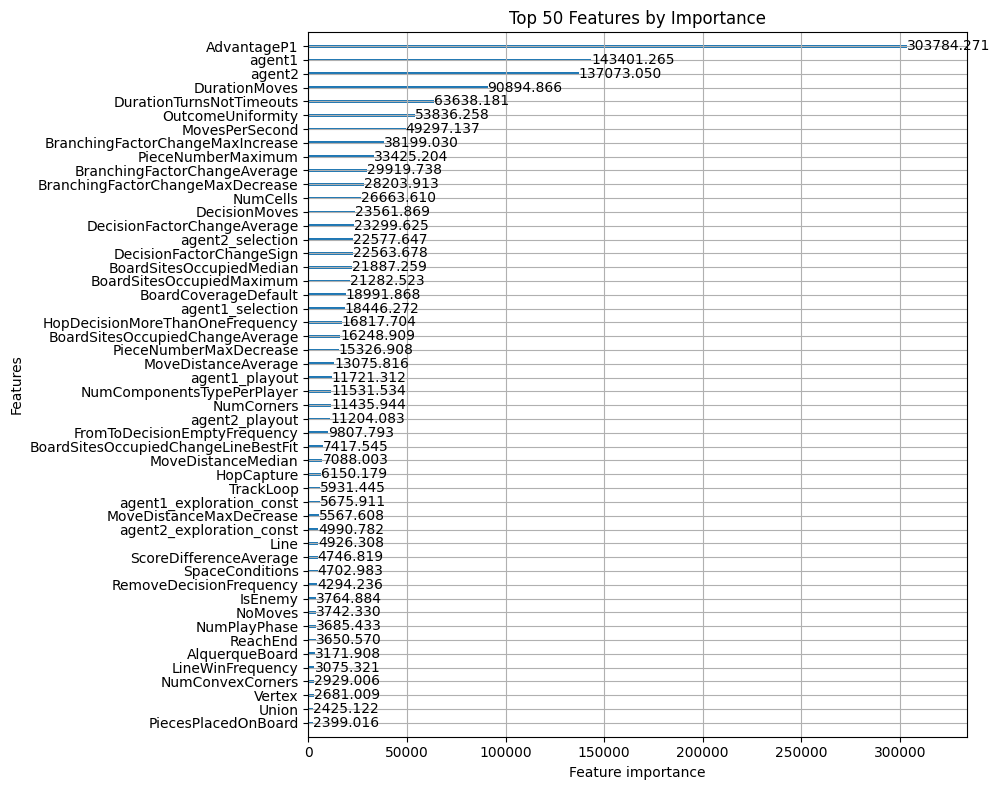

Fold 2 - RMSE: 0.4109421419458892
Fold 3


[100]	valid_0's rmse: 0.524202


[200]	valid_0's rmse: 0.499413


[300]	valid_0's rmse: 0.487178


[400]	valid_0's rmse: 0.479125


[500]	valid_0's rmse: 0.472808


[600]	valid_0's rmse: 0.467898


[700]	valid_0's rmse: 0.464275


[800]	valid_0's rmse: 0.46127


[900]	valid_0's rmse: 0.459187


[1000]	valid_0's rmse: 0.456817


[1100]	valid_0's rmse: 0.455036


[1200]	valid_0's rmse: 0.453521


[1300]	valid_0's rmse: 0.452386


[1400]	valid_0's rmse: 0.451259


[1500]	valid_0's rmse: 0.449868


[1600]	valid_0's rmse: 0.44883


[1700]	valid_0's rmse: 0.448076


[1800]	valid_0's rmse: 0.447348


[1900]	valid_0's rmse: 0.446677


[2000]	valid_0's rmse: 0.446072


[2100]	valid_0's rmse: 0.445678


[2200]	valid_0's rmse: 0.445024


[2300]	valid_0's rmse: 0.44458


[2400]	valid_0's rmse: 0.444106


[2500]	valid_0's rmse: 0.443567


[2600]	valid_0's rmse: 0.443244


[2700]	valid_0's rmse: 0.442759


[2800]	valid_0's rmse: 0.442365


[2900]	valid_0's rmse: 0.442024


[3000]	valid_0's rmse: 0.441838


[3100]	valid_0's rmse: 0.441471


[3200]	valid_0's rmse: 0.441312


[3300]	valid_0's rmse: 0.44106


[3400]	valid_0's rmse: 0.440764


[3500]	valid_0's rmse: 0.440544


[3600]	valid_0's rmse: 0.440305


[3700]	valid_0's rmse: 0.440093


[3800]	valid_0's rmse: 0.439826


[3900]	valid_0's rmse: 0.439618


[4000]	valid_0's rmse: 0.439413


[4100]	valid_0's rmse: 0.439258


[4200]	valid_0's rmse: 0.439056


[4300]	valid_0's rmse: 0.438903


[4400]	valid_0's rmse: 0.438744


[4500]	valid_0's rmse: 0.438635


[4600]	valid_0's rmse: 0.438503


[4700]	valid_0's rmse: 0.438254


[4800]	valid_0's rmse: 0.438163


[4900]	valid_0's rmse: 0.438064


[5000]	valid_0's rmse: 0.437909


[5100]	valid_0's rmse: 0.437815


[5200]	valid_0's rmse: 0.437626


[5300]	valid_0's rmse: 0.437521


[5400]	valid_0's rmse: 0.437339


[5500]	valid_0's rmse: 0.437233


[5600]	valid_0's rmse: 0.437148


[5700]	valid_0's rmse: 0.437021


[5800]	valid_0's rmse: 0.436983


[5900]	valid_0's rmse: 0.436926


[6000]	valid_0's rmse: 0.436831


[6100]	valid_0's rmse: 0.436718


[6200]	valid_0's rmse: 0.436623


[6300]	valid_0's rmse: 0.436585


[6400]	valid_0's rmse: 0.436513


[6500]	valid_0's rmse: 0.43649


[6600]	valid_0's rmse: 0.436383


[6700]	valid_0's rmse: 0.436282


[6800]	valid_0's rmse: 0.436206


[6900]	valid_0's rmse: 0.436144


[7000]	valid_0's rmse: 0.436068


[7100]	valid_0's rmse: 0.436014


[7200]	valid_0's rmse: 0.435958


[7300]	valid_0's rmse: 0.435811


[7400]	valid_0's rmse: 0.435666


[7500]	valid_0's rmse: 0.435603


[7600]	valid_0's rmse: 0.435537


[7700]	valid_0's rmse: 0.435478


[7800]	valid_0's rmse: 0.435375


[7900]	valid_0's rmse: 0.435336


[8000]	valid_0's rmse: 0.435232


[8100]	valid_0's rmse: 0.43521


[8200]	valid_0's rmse: 0.435165


[8300]	valid_0's rmse: 0.435162


[8400]	valid_0's rmse: 0.435055


[8500]	valid_0's rmse: 0.435008


[8600]	valid_0's rmse: 0.434961


[8700]	valid_0's rmse: 0.434935


[8800]	valid_0's rmse: 0.434895


[8900]	valid_0's rmse: 0.434955


[9000]	valid_0's rmse: 0.434974


[9100]	valid_0's rmse: 0.434889


[9200]	valid_0's rmse: 0.434863


[9300]	valid_0's rmse: 0.434833


[9400]	valid_0's rmse: 0.434802


[9500]	valid_0's rmse: 0.434776


[9600]	valid_0's rmse: 0.434679


[9700]	valid_0's rmse: 0.434618


[9800]	valid_0's rmse: 0.434605


[9900]	valid_0's rmse: 0.434606


[10000]	valid_0's rmse: 0.434573


Fold 3 - RMSE: 0.43393566947276946
Fold 4


[100]	valid_0's rmse: 0.524507


[200]	valid_0's rmse: 0.498683


[300]	valid_0's rmse: 0.486167


[400]	valid_0's rmse: 0.477042


[500]	valid_0's rmse: 0.471209


[600]	valid_0's rmse: 0.466104


[700]	valid_0's rmse: 0.462451


[800]	valid_0's rmse: 0.459923


[900]	valid_0's rmse: 0.457826


[1000]	valid_0's rmse: 0.455776


[1100]	valid_0's rmse: 0.454118


[1200]	valid_0's rmse: 0.452818


[1300]	valid_0's rmse: 0.451612


[1400]	valid_0's rmse: 0.450634


[1500]	valid_0's rmse: 0.449896


[1600]	valid_0's rmse: 0.449211


[1700]	valid_0's rmse: 0.448571


[1800]	valid_0's rmse: 0.447865


[1900]	valid_0's rmse: 0.447281


[2000]	valid_0's rmse: 0.446746


[2100]	valid_0's rmse: 0.446435


[2200]	valid_0's rmse: 0.446022


[2300]	valid_0's rmse: 0.445612


[2400]	valid_0's rmse: 0.445181


[2500]	valid_0's rmse: 0.44486


[2600]	valid_0's rmse: 0.444524


[2700]	valid_0's rmse: 0.444113


[2800]	valid_0's rmse: 0.443908


[2900]	valid_0's rmse: 0.443719


[3000]	valid_0's rmse: 0.44354


[3100]	valid_0's rmse: 0.443309


[3200]	valid_0's rmse: 0.443007


[3300]	valid_0's rmse: 0.442889


[3400]	valid_0's rmse: 0.442802


[3500]	valid_0's rmse: 0.442667


[3600]	valid_0's rmse: 0.442453


[3700]	valid_0's rmse: 0.442349


[3800]	valid_0's rmse: 0.442282


[3900]	valid_0's rmse: 0.44218


[4000]	valid_0's rmse: 0.442076


[4100]	valid_0's rmse: 0.44195


[4200]	valid_0's rmse: 0.4418


[4300]	valid_0's rmse: 0.441685


[4400]	valid_0's rmse: 0.441551


[4500]	valid_0's rmse: 0.441474


[4600]	valid_0's rmse: 0.441374


[4700]	valid_0's rmse: 0.44116


[4800]	valid_0's rmse: 0.441026


[4900]	valid_0's rmse: 0.440936


[5000]	valid_0's rmse: 0.440787


[5100]	valid_0's rmse: 0.440682


[5200]	valid_0's rmse: 0.440651


[5300]	valid_0's rmse: 0.440553


[5400]	valid_0's rmse: 0.440434


[5500]	valid_0's rmse: 0.440331


[5600]	valid_0's rmse: 0.440235


[5700]	valid_0's rmse: 0.440136


[5800]	valid_0's rmse: 0.440111


[5900]	valid_0's rmse: 0.440016


[6000]	valid_0's rmse: 0.439953


[6100]	valid_0's rmse: 0.439949


[6200]	valid_0's rmse: 0.439896


[6300]	valid_0's rmse: 0.439934


[6400]	valid_0's rmse: 0.439886


[6500]	valid_0's rmse: 0.439802


[6600]	valid_0's rmse: 0.439766


[6700]	valid_0's rmse: 0.439656


[6800]	valid_0's rmse: 0.439639


[6900]	valid_0's rmse: 0.439626


[7000]	valid_0's rmse: 0.439594


[7100]	valid_0's rmse: 0.439572


[7200]	valid_0's rmse: 0.439567


[7300]	valid_0's rmse: 0.4395


[7400]	valid_0's rmse: 0.439498


[7500]	valid_0's rmse: 0.439458


[7600]	valid_0's rmse: 0.439423


[7700]	valid_0's rmse: 0.43931


[7800]	valid_0's rmse: 0.439271


[7900]	valid_0's rmse: 0.439235


[8000]	valid_0's rmse: 0.439207


[8100]	valid_0's rmse: 0.439147


[8200]	valid_0's rmse: 0.439145


[8300]	valid_0's rmse: 0.439132


[8400]	valid_0's rmse: 0.439125


[8500]	valid_0's rmse: 0.439062


[8600]	valid_0's rmse: 0.439045


[8700]	valid_0's rmse: 0.439065


[8800]	valid_0's rmse: 0.439017


[8900]	valid_0's rmse: 0.438967


[9000]	valid_0's rmse: 0.438893


[9100]	valid_0's rmse: 0.438897


[9200]	valid_0's rmse: 0.438848


[9300]	valid_0's rmse: 0.438833


[9400]	valid_0's rmse: 0.438888


[9500]	valid_0's rmse: 0.438839


[9600]	valid_0's rmse: 0.438846


[9700]	valid_0's rmse: 0.438837


[9800]	valid_0's rmse: 0.438814


[9900]	valid_0's rmse: 0.438828


[10000]	valid_0's rmse: 0.438811


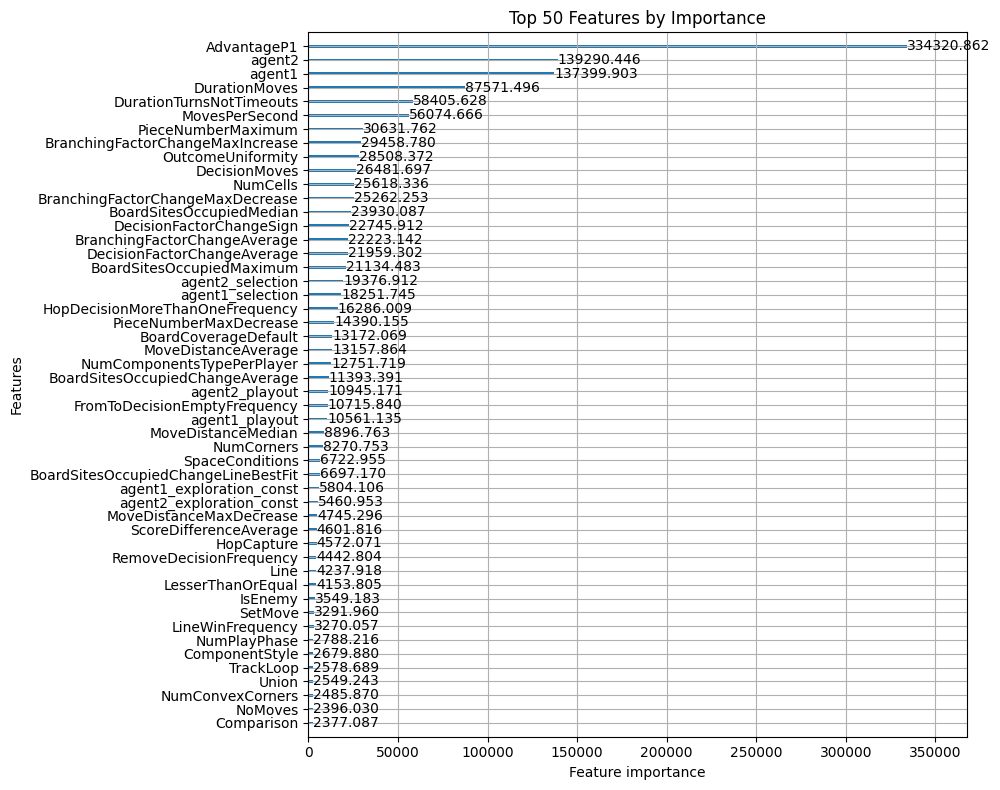

Fold 4 - RMSE: 0.4383778206728412
Fold 5


[100]	valid_0's rmse: 0.515521


[200]	valid_0's rmse: 0.494915


[300]	valid_0's rmse: 0.481407


[400]	valid_0's rmse: 0.473119


[500]	valid_0's rmse: 0.467157


[600]	valid_0's rmse: 0.462916


[700]	valid_0's rmse: 0.459271


[800]	valid_0's rmse: 0.456009


[900]	valid_0's rmse: 0.453324


[1000]	valid_0's rmse: 0.451213


[1100]	valid_0's rmse: 0.44944


[1200]	valid_0's rmse: 0.447965


[1300]	valid_0's rmse: 0.446428


[1400]	valid_0's rmse: 0.444847


[1500]	valid_0's rmse: 0.443711


[1600]	valid_0's rmse: 0.442953


[1700]	valid_0's rmse: 0.442232


[1800]	valid_0's rmse: 0.441453


[1900]	valid_0's rmse: 0.440859


[2000]	valid_0's rmse: 0.440362


[2100]	valid_0's rmse: 0.439801


[2200]	valid_0's rmse: 0.4393


[2300]	valid_0's rmse: 0.438759


[2400]	valid_0's rmse: 0.438278


[2500]	valid_0's rmse: 0.43784


[2600]	valid_0's rmse: 0.437465


[2700]	valid_0's rmse: 0.437087


[2800]	valid_0's rmse: 0.436729


[2900]	valid_0's rmse: 0.43649


[3000]	valid_0's rmse: 0.436294


[3100]	valid_0's rmse: 0.436043


[3200]	valid_0's rmse: 0.435776


[3300]	valid_0's rmse: 0.435556


[3400]	valid_0's rmse: 0.435412


[3500]	valid_0's rmse: 0.435107


[3600]	valid_0's rmse: 0.434775


[3700]	valid_0's rmse: 0.43451


[3800]	valid_0's rmse: 0.434323


[3900]	valid_0's rmse: 0.434134


[4000]	valid_0's rmse: 0.433901


[4100]	valid_0's rmse: 0.433814


[4200]	valid_0's rmse: 0.433588


[4300]	valid_0's rmse: 0.43345


[4400]	valid_0's rmse: 0.433316


[4500]	valid_0's rmse: 0.433129


[4600]	valid_0's rmse: 0.433017


[4700]	valid_0's rmse: 0.432834


[4800]	valid_0's rmse: 0.432713


[4900]	valid_0's rmse: 0.432556


[5000]	valid_0's rmse: 0.432476


[5100]	valid_0's rmse: 0.432354


[5200]	valid_0's rmse: 0.432325


[5300]	valid_0's rmse: 0.432244


[5400]	valid_0's rmse: 0.432181


[5500]	valid_0's rmse: 0.432063


[5600]	valid_0's rmse: 0.431961


[5700]	valid_0's rmse: 0.431827


[5800]	valid_0's rmse: 0.431712


[5900]	valid_0's rmse: 0.431613


[6000]	valid_0's rmse: 0.431566


[6100]	valid_0's rmse: 0.431465


[6200]	valid_0's rmse: 0.431469


[6300]	valid_0's rmse: 0.431437


[6400]	valid_0's rmse: 0.431353


[6500]	valid_0's rmse: 0.431313


[6600]	valid_0's rmse: 0.431278


[6700]	valid_0's rmse: 0.431235


[6800]	valid_0's rmse: 0.431133


[6900]	valid_0's rmse: 0.431042


[7000]	valid_0's rmse: 0.43106


[7100]	valid_0's rmse: 0.431004


[7200]	valid_0's rmse: 0.43101


[7300]	valid_0's rmse: 0.431006


[7400]	valid_0's rmse: 0.430932


[7500]	valid_0's rmse: 0.430875


[7600]	valid_0's rmse: 0.430852


[7700]	valid_0's rmse: 0.430783


[7800]	valid_0's rmse: 0.430729


[7900]	valid_0's rmse: 0.430717


[8000]	valid_0's rmse: 0.430684


[8100]	valid_0's rmse: 0.430602


[8200]	valid_0's rmse: 0.430656


[8300]	valid_0's rmse: 0.430614


[8400]	valid_0's rmse: 0.430606


[8500]	valid_0's rmse: 0.430559


[8600]	valid_0's rmse: 0.430579


[8700]	valid_0's rmse: 0.430558


[8800]	valid_0's rmse: 0.430564


[8900]	valid_0's rmse: 0.430551


[9000]	valid_0's rmse: 0.430487


[9100]	valid_0's rmse: 0.430466


[9200]	valid_0's rmse: 0.43041


[9300]	valid_0's rmse: 0.430405


[9400]	valid_0's rmse: 0.43042


[9500]	valid_0's rmse: 0.430397


[9600]	valid_0's rmse: 0.430398


[9700]	valid_0's rmse: 0.430415


[9800]	valid_0's rmse: 0.430392


[9900]	valid_0's rmse: 0.430393


[10000]	valid_0's rmse: 0.430391


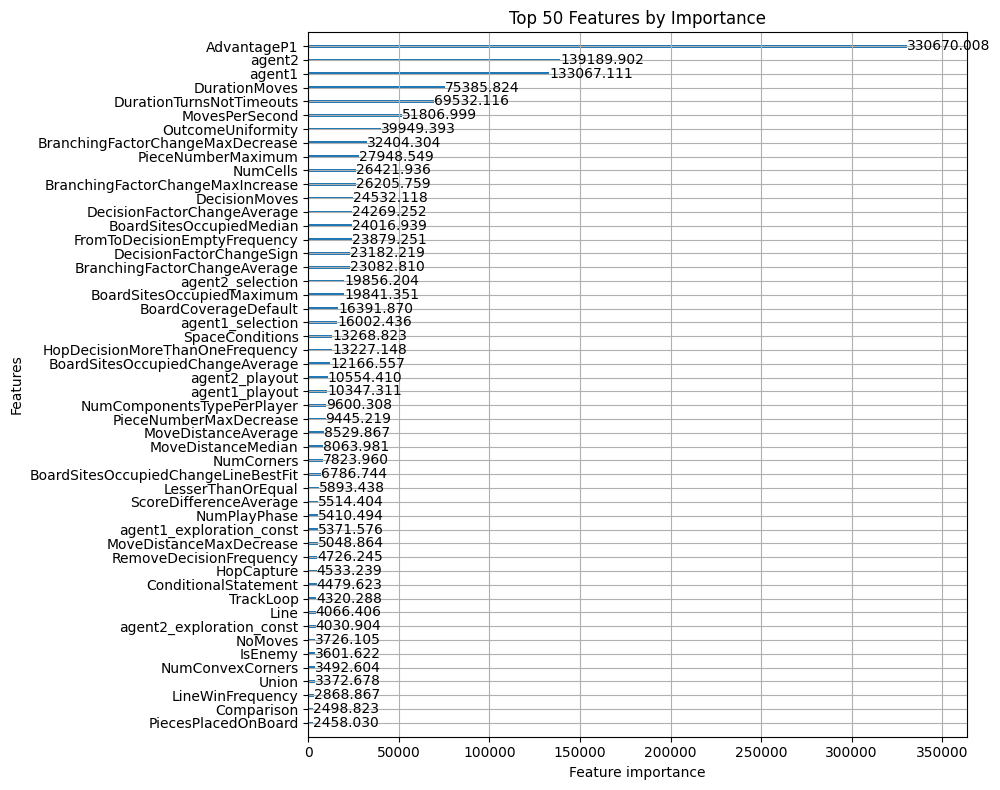

Fold 5 - RMSE: 0.4298909426293761
List of oof scores: [0.42067122161304343, 0.4109421419458892, 0.43393566947276946, 0.4383778206728412, 0.4298909426293761]
Average oof score: 0.4267635592667839


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv2.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.510832


[200]	valid_0's rmse: 0.485311


[300]	valid_0's rmse: 0.473623


[400]	valid_0's rmse: 0.466796


[500]	valid_0's rmse: 0.462765


[600]	valid_0's rmse: 0.459179


[700]	valid_0's rmse: 0.455851


[800]	valid_0's rmse: 0.45348


[900]	valid_0's rmse: 0.451544


[1000]	valid_0's rmse: 0.449757


[1100]	valid_0's rmse: 0.448461


[1200]	valid_0's rmse: 0.447391


[1300]	valid_0's rmse: 0.446485


[1400]	valid_0's rmse: 0.445598


[1500]	valid_0's rmse: 0.444984


[1600]	valid_0's rmse: 0.444322


[1700]	valid_0's rmse: 0.443975


[1800]	valid_0's rmse: 0.443551


[1900]	valid_0's rmse: 0.443048


[2000]	valid_0's rmse: 0.442561


[2100]	valid_0's rmse: 0.442312


[2200]	valid_0's rmse: 0.442028


[2300]	valid_0's rmse: 0.441564


[2400]	valid_0's rmse: 0.441132


[2500]	valid_0's rmse: 0.440875


[2600]	valid_0's rmse: 0.440673


[2700]	valid_0's rmse: 0.440298


[2800]	valid_0's rmse: 0.440014


[2900]	valid_0's rmse: 0.439724


[3000]	valid_0's rmse: 0.439541


[3100]	valid_0's rmse: 0.439322


[3200]	valid_0's rmse: 0.439131


[3300]	valid_0's rmse: 0.438899


[3400]	valid_0's rmse: 0.438715


[3500]	valid_0's rmse: 0.438554


[3600]	valid_0's rmse: 0.438458


[3700]	valid_0's rmse: 0.43823


[3800]	valid_0's rmse: 0.438132


[3900]	valid_0's rmse: 0.437957


[4000]	valid_0's rmse: 0.437829


[4100]	valid_0's rmse: 0.437825


[4200]	valid_0's rmse: 0.437637


[4300]	valid_0's rmse: 0.437586


[4400]	valid_0's rmse: 0.4375


[4500]	valid_0's rmse: 0.437377


[4600]	valid_0's rmse: 0.43726


[4700]	valid_0's rmse: 0.43724


[4800]	valid_0's rmse: 0.437242


[4900]	valid_0's rmse: 0.437178


[5000]	valid_0's rmse: 0.437129


[5100]	valid_0's rmse: 0.437017


[5200]	valid_0's rmse: 0.436916


[5300]	valid_0's rmse: 0.436806


[5400]	valid_0's rmse: 0.436687


[5500]	valid_0's rmse: 0.436613


[5600]	valid_0's rmse: 0.436519


[5700]	valid_0's rmse: 0.436457


[5800]	valid_0's rmse: 0.436368


[5900]	valid_0's rmse: 0.436331


[6000]	valid_0's rmse: 0.436242


[6100]	valid_0's rmse: 0.436166


[6200]	valid_0's rmse: 0.436078


[6300]	valid_0's rmse: 0.436065


[6400]	valid_0's rmse: 0.436016


[6500]	valid_0's rmse: 0.435975


[6600]	valid_0's rmse: 0.435918


[6700]	valid_0's rmse: 0.435895


[6800]	valid_0's rmse: 0.435836


[6900]	valid_0's rmse: 0.435865


[7000]	valid_0's rmse: 0.435924


[7100]	valid_0's rmse: 0.435913


[7200]	valid_0's rmse: 0.435878


[7300]	valid_0's rmse: 0.43584


[7400]	valid_0's rmse: 0.435892


[7500]	valid_0's rmse: 0.435798


[7600]	valid_0's rmse: 0.435767


[7700]	valid_0's rmse: 0.43575


[7800]	valid_0's rmse: 0.435697


[7900]	valid_0's rmse: 0.435706


[8000]	valid_0's rmse: 0.435646


[8100]	valid_0's rmse: 0.435606


[8200]	valid_0's rmse: 0.435582


[8300]	valid_0's rmse: 0.43556


[8400]	valid_0's rmse: 0.435553


[8500]	valid_0's rmse: 0.435554


[8600]	valid_0's rmse: 0.435512


[8700]	valid_0's rmse: 0.435477


[8800]	valid_0's rmse: 0.43546


[8900]	valid_0's rmse: 0.435475


[9000]	valid_0's rmse: 0.435436


[9100]	valid_0's rmse: 0.435443


[9200]	valid_0's rmse: 0.435386


[9300]	valid_0's rmse: 0.435332


[9400]	valid_0's rmse: 0.43532


[9500]	valid_0's rmse: 0.435299


[9600]	valid_0's rmse: 0.435265


[9700]	valid_0's rmse: 0.435273


[9800]	valid_0's rmse: 0.435327


[9900]	valid_0's rmse: 0.435302


[10000]	valid_0's rmse: 0.435298


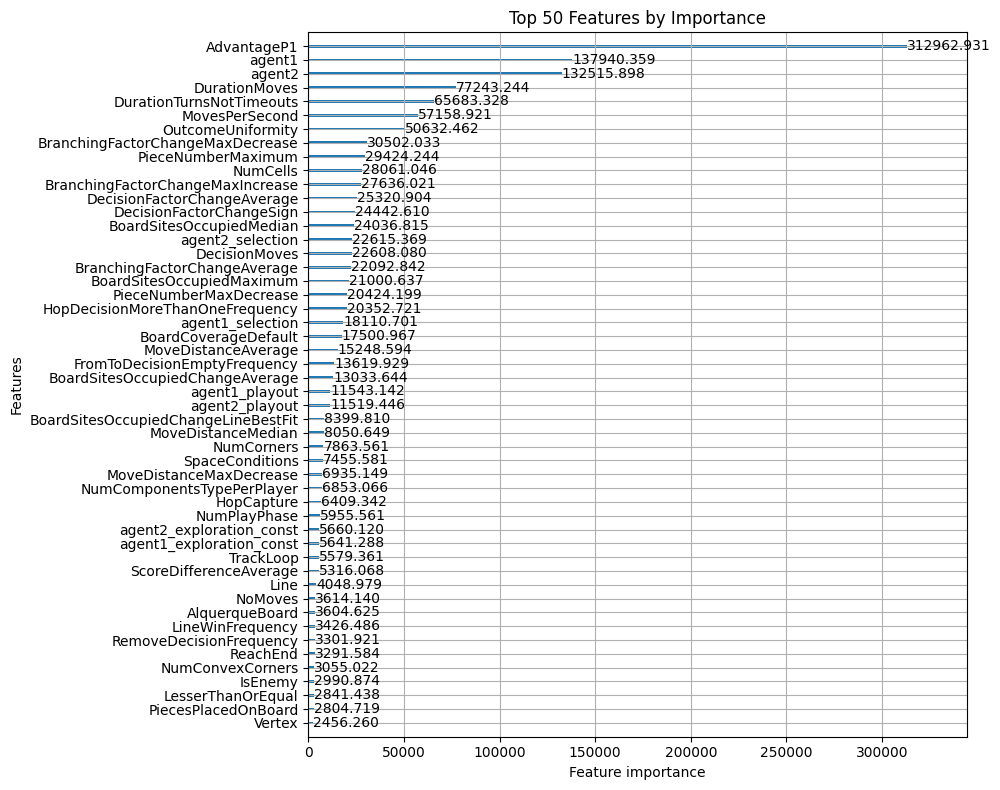

Fold 1 - RMSE: 0.43494924748019653
Fold 2


[100]	valid_0's rmse: 0.508652


[200]	valid_0's rmse: 0.488691


[300]	valid_0's rmse: 0.478277


[400]	valid_0's rmse: 0.471422


[500]	valid_0's rmse: 0.46627


[600]	valid_0's rmse: 0.462417


[700]	valid_0's rmse: 0.458342


[800]	valid_0's rmse: 0.455436


[900]	valid_0's rmse: 0.45318


[1000]	valid_0's rmse: 0.450923


[1100]	valid_0's rmse: 0.448722


[1200]	valid_0's rmse: 0.447057


[1300]	valid_0's rmse: 0.44571


[1400]	valid_0's rmse: 0.444562


[1500]	valid_0's rmse: 0.443514


[1600]	valid_0's rmse: 0.442741


[1700]	valid_0's rmse: 0.441966


[1800]	valid_0's rmse: 0.441168


[1900]	valid_0's rmse: 0.440236


[2000]	valid_0's rmse: 0.439441


[2100]	valid_0's rmse: 0.438898


[2200]	valid_0's rmse: 0.438361


[2300]	valid_0's rmse: 0.437944


[2400]	valid_0's rmse: 0.437483


[2500]	valid_0's rmse: 0.43708


[2600]	valid_0's rmse: 0.436659


[2700]	valid_0's rmse: 0.436229


[2800]	valid_0's rmse: 0.435988


[2900]	valid_0's rmse: 0.435658


[3000]	valid_0's rmse: 0.435268


[3100]	valid_0's rmse: 0.434836


[3200]	valid_0's rmse: 0.434549


[3300]	valid_0's rmse: 0.434215


[3400]	valid_0's rmse: 0.433898


[3500]	valid_0's rmse: 0.433518


[3600]	valid_0's rmse: 0.433404


[3700]	valid_0's rmse: 0.433111


[3800]	valid_0's rmse: 0.43293


[3900]	valid_0's rmse: 0.432725


[4000]	valid_0's rmse: 0.432557


[4100]	valid_0's rmse: 0.432461


[4200]	valid_0's rmse: 0.432231


[4300]	valid_0's rmse: 0.432168


[4400]	valid_0's rmse: 0.431958


[4500]	valid_0's rmse: 0.431761


[4600]	valid_0's rmse: 0.43161


[4700]	valid_0's rmse: 0.431434


[4800]	valid_0's rmse: 0.431321


[4900]	valid_0's rmse: 0.431178


[5000]	valid_0's rmse: 0.431067


[5100]	valid_0's rmse: 0.430957


[5200]	valid_0's rmse: 0.430842


[5300]	valid_0's rmse: 0.430707


[5400]	valid_0's rmse: 0.430605


[5500]	valid_0's rmse: 0.430568


[5600]	valid_0's rmse: 0.430414


[5700]	valid_0's rmse: 0.430308


[5800]	valid_0's rmse: 0.430267


[5900]	valid_0's rmse: 0.430197


[6000]	valid_0's rmse: 0.430155


[6100]	valid_0's rmse: 0.430154


[6200]	valid_0's rmse: 0.430075


[6300]	valid_0's rmse: 0.429936


[6400]	valid_0's rmse: 0.429923


[6500]	valid_0's rmse: 0.429844


[6600]	valid_0's rmse: 0.42978


[6700]	valid_0's rmse: 0.429725


[6800]	valid_0's rmse: 0.429646


[6900]	valid_0's rmse: 0.429532


[7000]	valid_0's rmse: 0.429458


[7100]	valid_0's rmse: 0.429409


[7200]	valid_0's rmse: 0.42931


[7300]	valid_0's rmse: 0.429276


[7400]	valid_0's rmse: 0.429229


[7500]	valid_0's rmse: 0.42914


[7600]	valid_0's rmse: 0.429009


[7700]	valid_0's rmse: 0.428925


[7800]	valid_0's rmse: 0.428862


[7900]	valid_0's rmse: 0.42878


[8000]	valid_0's rmse: 0.428754


[8100]	valid_0's rmse: 0.428713


[8200]	valid_0's rmse: 0.428583


[8300]	valid_0's rmse: 0.428555


[8400]	valid_0's rmse: 0.428489


[8500]	valid_0's rmse: 0.428394


[8600]	valid_0's rmse: 0.428378


[8700]	valid_0's rmse: 0.428329


[8800]	valid_0's rmse: 0.428277


[8900]	valid_0's rmse: 0.428261


[9000]	valid_0's rmse: 0.428257


[9100]	valid_0's rmse: 0.428222


[9200]	valid_0's rmse: 0.428192


[9300]	valid_0's rmse: 0.428082


[9400]	valid_0's rmse: 0.428066


[9500]	valid_0's rmse: 0.428043


[9600]	valid_0's rmse: 0.427986


[9700]	valid_0's rmse: 0.427926


[9800]	valid_0's rmse: 0.427871


[9900]	valid_0's rmse: 0.42784


[10000]	valid_0's rmse: 0.42779


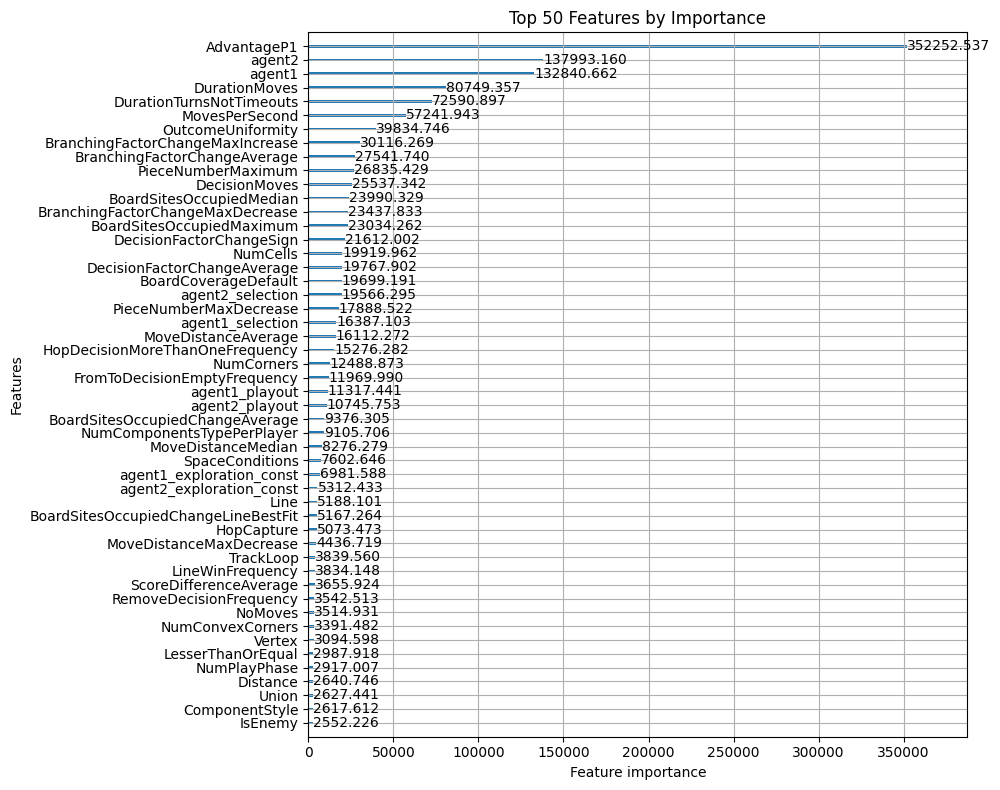

Fold 2 - RMSE: 0.42731399051622676
Fold 3


[100]	valid_0's rmse: 0.497102


[200]	valid_0's rmse: 0.476744


[300]	valid_0's rmse: 0.467415


[400]	valid_0's rmse: 0.461991


[500]	valid_0's rmse: 0.458319


[600]	valid_0's rmse: 0.455124


[700]	valid_0's rmse: 0.452155


[800]	valid_0's rmse: 0.449906


[900]	valid_0's rmse: 0.447837


[1000]	valid_0's rmse: 0.446335


[1100]	valid_0's rmse: 0.444811


[1200]	valid_0's rmse: 0.443522


[1300]	valid_0's rmse: 0.442723


[1400]	valid_0's rmse: 0.441667


[1500]	valid_0's rmse: 0.440894


[1600]	valid_0's rmse: 0.440319


[1700]	valid_0's rmse: 0.439578


[1800]	valid_0's rmse: 0.438973


[1900]	valid_0's rmse: 0.438473


[2000]	valid_0's rmse: 0.437922


[2100]	valid_0's rmse: 0.437506


[2200]	valid_0's rmse: 0.437106


[2300]	valid_0's rmse: 0.436792


[2400]	valid_0's rmse: 0.436246


[2500]	valid_0's rmse: 0.43584


[2600]	valid_0's rmse: 0.435494


[2700]	valid_0's rmse: 0.435193


[2800]	valid_0's rmse: 0.434942


[2900]	valid_0's rmse: 0.434669


[3000]	valid_0's rmse: 0.434374


[3100]	valid_0's rmse: 0.434152


[3200]	valid_0's rmse: 0.433918


[3300]	valid_0's rmse: 0.433827


[3400]	valid_0's rmse: 0.433592


[3500]	valid_0's rmse: 0.433491


[3600]	valid_0's rmse: 0.433377


[3700]	valid_0's rmse: 0.433234


[3800]	valid_0's rmse: 0.43308


[3900]	valid_0's rmse: 0.432847


[4000]	valid_0's rmse: 0.432743


[4100]	valid_0's rmse: 0.432645


[4200]	valid_0's rmse: 0.432474


[4300]	valid_0's rmse: 0.432394


[4400]	valid_0's rmse: 0.432265


[4500]	valid_0's rmse: 0.432128


[4600]	valid_0's rmse: 0.432056


[4700]	valid_0's rmse: 0.431963


[4800]	valid_0's rmse: 0.431883


[4900]	valid_0's rmse: 0.431737


[5000]	valid_0's rmse: 0.431682


[5100]	valid_0's rmse: 0.431602


[5200]	valid_0's rmse: 0.431481


[5300]	valid_0's rmse: 0.431408


[5400]	valid_0's rmse: 0.431316


[5500]	valid_0's rmse: 0.431253


[5600]	valid_0's rmse: 0.431149


[5700]	valid_0's rmse: 0.431015


[5800]	valid_0's rmse: 0.4309


[5900]	valid_0's rmse: 0.430853


[6000]	valid_0's rmse: 0.430842


[6100]	valid_0's rmse: 0.430792


[6200]	valid_0's rmse: 0.430745


[6300]	valid_0's rmse: 0.430705


[6400]	valid_0's rmse: 0.430601


[6500]	valid_0's rmse: 0.430607


[6600]	valid_0's rmse: 0.430642


[6700]	valid_0's rmse: 0.430628


[6800]	valid_0's rmse: 0.430561


[6900]	valid_0's rmse: 0.4305


[7000]	valid_0's rmse: 0.430492


[7100]	valid_0's rmse: 0.430417


[7200]	valid_0's rmse: 0.430397


[7300]	valid_0's rmse: 0.430329


[7400]	valid_0's rmse: 0.430319


[7500]	valid_0's rmse: 0.430218


[7600]	valid_0's rmse: 0.430224


[7700]	valid_0's rmse: 0.430225


[7800]	valid_0's rmse: 0.430204


[7900]	valid_0's rmse: 0.430213


[8000]	valid_0's rmse: 0.430158


[8100]	valid_0's rmse: 0.430026


[8200]	valid_0's rmse: 0.429995


[8300]	valid_0's rmse: 0.429967


[8400]	valid_0's rmse: 0.429935


[8500]	valid_0's rmse: 0.429885


[8600]	valid_0's rmse: 0.429866


[8700]	valid_0's rmse: 0.429859


[8800]	valid_0's rmse: 0.429785


[8900]	valid_0's rmse: 0.429702


[9000]	valid_0's rmse: 0.429746


[9100]	valid_0's rmse: 0.429733


[9200]	valid_0's rmse: 0.429691


[9300]	valid_0's rmse: 0.429726


[9400]	valid_0's rmse: 0.429665


[9500]	valid_0's rmse: 0.429635


[9600]	valid_0's rmse: 0.429645


[9700]	valid_0's rmse: 0.429595


[9800]	valid_0's rmse: 0.429553


[9900]	valid_0's rmse: 0.429506


[10000]	valid_0's rmse: 0.42952


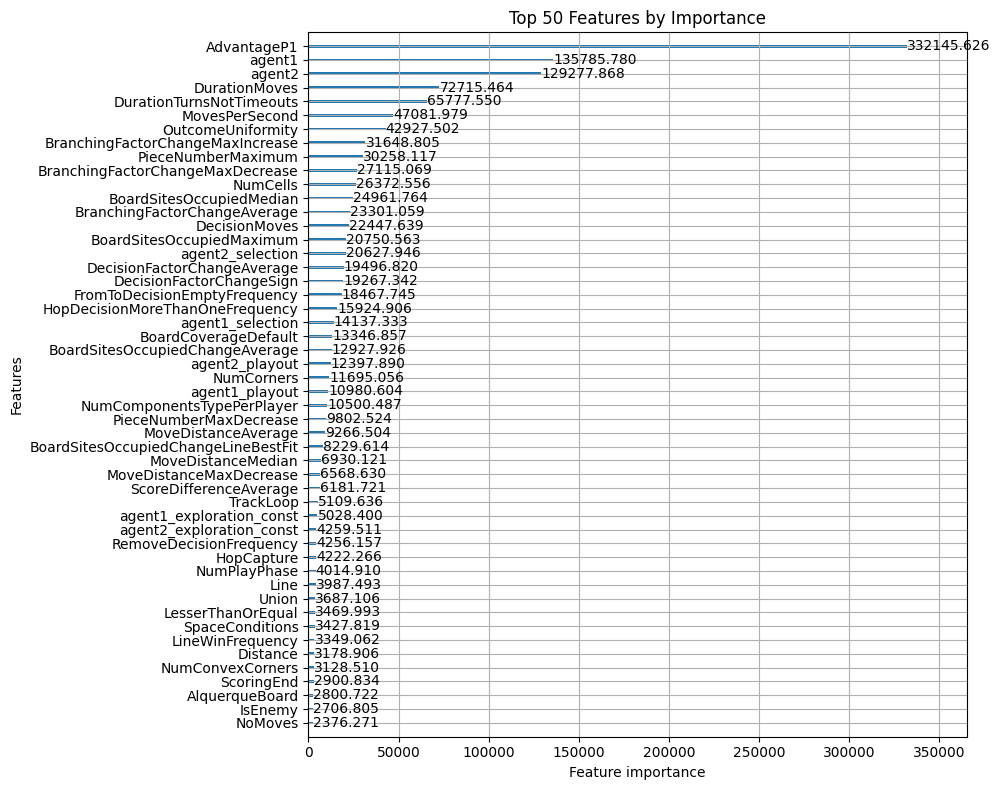

Fold 3 - RMSE: 0.428900824071964
Fold 4


[100]	valid_0's rmse: 0.490575


[200]	valid_0's rmse: 0.467446


[300]	valid_0's rmse: 0.45736


[400]	valid_0's rmse: 0.451068


[500]	valid_0's rmse: 0.446557


[600]	valid_0's rmse: 0.442967


[700]	valid_0's rmse: 0.440411


[800]	valid_0's rmse: 0.4386


[900]	valid_0's rmse: 0.437102


[1000]	valid_0's rmse: 0.435559


[1100]	valid_0's rmse: 0.434292


[1200]	valid_0's rmse: 0.433292


[1300]	valid_0's rmse: 0.43259


[1400]	valid_0's rmse: 0.431813


[1500]	valid_0's rmse: 0.431122


[1600]	valid_0's rmse: 0.430447


[1700]	valid_0's rmse: 0.429934


[1800]	valid_0's rmse: 0.429493


[1900]	valid_0's rmse: 0.429056


[2000]	valid_0's rmse: 0.428677


[2100]	valid_0's rmse: 0.428261


[2200]	valid_0's rmse: 0.427968


[2300]	valid_0's rmse: 0.427545


[2400]	valid_0's rmse: 0.427301


[2500]	valid_0's rmse: 0.42692


[2600]	valid_0's rmse: 0.426626


[2700]	valid_0's rmse: 0.426384


[2800]	valid_0's rmse: 0.42618


[2900]	valid_0's rmse: 0.425907


[3000]	valid_0's rmse: 0.425732


[3100]	valid_0's rmse: 0.425442


[3200]	valid_0's rmse: 0.425282


[3300]	valid_0's rmse: 0.425182


[3400]	valid_0's rmse: 0.425021


[3500]	valid_0's rmse: 0.424861


[3600]	valid_0's rmse: 0.424818


[3700]	valid_0's rmse: 0.424721


[3800]	valid_0's rmse: 0.424645


[3900]	valid_0's rmse: 0.424573


[4000]	valid_0's rmse: 0.424545


[4100]	valid_0's rmse: 0.42438


[4200]	valid_0's rmse: 0.424357


[4300]	valid_0's rmse: 0.424277


[4400]	valid_0's rmse: 0.424179


[4500]	valid_0's rmse: 0.424101


[4600]	valid_0's rmse: 0.424033


[4700]	valid_0's rmse: 0.423883


[4800]	valid_0's rmse: 0.423794


[4900]	valid_0's rmse: 0.423736


[5000]	valid_0's rmse: 0.423687


[5100]	valid_0's rmse: 0.423617


[5200]	valid_0's rmse: 0.423491


[5300]	valid_0's rmse: 0.423465


[5400]	valid_0's rmse: 0.42339


[5500]	valid_0's rmse: 0.423321


[5600]	valid_0's rmse: 0.423341


[5700]	valid_0's rmse: 0.423361


[5800]	valid_0's rmse: 0.423316


[5900]	valid_0's rmse: 0.423373


[6000]	valid_0's rmse: 0.423317


[6100]	valid_0's rmse: 0.423234


[6200]	valid_0's rmse: 0.423235


[6300]	valid_0's rmse: 0.423175


[6400]	valid_0's rmse: 0.423135


[6500]	valid_0's rmse: 0.42305


[6600]	valid_0's rmse: 0.423019


[6700]	valid_0's rmse: 0.422972


[6800]	valid_0's rmse: 0.422906


[6900]	valid_0's rmse: 0.422849


[7000]	valid_0's rmse: 0.422889


[7100]	valid_0's rmse: 0.422839


[7200]	valid_0's rmse: 0.422808


[7300]	valid_0's rmse: 0.422793


[7400]	valid_0's rmse: 0.422752


[7500]	valid_0's rmse: 0.422745


[7600]	valid_0's rmse: 0.422664


[7700]	valid_0's rmse: 0.422655


[7800]	valid_0's rmse: 0.422608


[7900]	valid_0's rmse: 0.422598


[8000]	valid_0's rmse: 0.422562


[8100]	valid_0's rmse: 0.422493


[8200]	valid_0's rmse: 0.422487


[8300]	valid_0's rmse: 0.422448


[8400]	valid_0's rmse: 0.422463


[8500]	valid_0's rmse: 0.422448


[8600]	valid_0's rmse: 0.42244


[8700]	valid_0's rmse: 0.422438


[8800]	valid_0's rmse: 0.422414


[8900]	valid_0's rmse: 0.422332


[9000]	valid_0's rmse: 0.422282


[9100]	valid_0's rmse: 0.422308


[9200]	valid_0's rmse: 0.422294


[9300]	valid_0's rmse: 0.422292


[9400]	valid_0's rmse: 0.422336


[9500]	valid_0's rmse: 0.422301


[9600]	valid_0's rmse: 0.422246


[9700]	valid_0's rmse: 0.422229


[9800]	valid_0's rmse: 0.422198


[9900]	valid_0's rmse: 0.422176


[10000]	valid_0's rmse: 0.422175


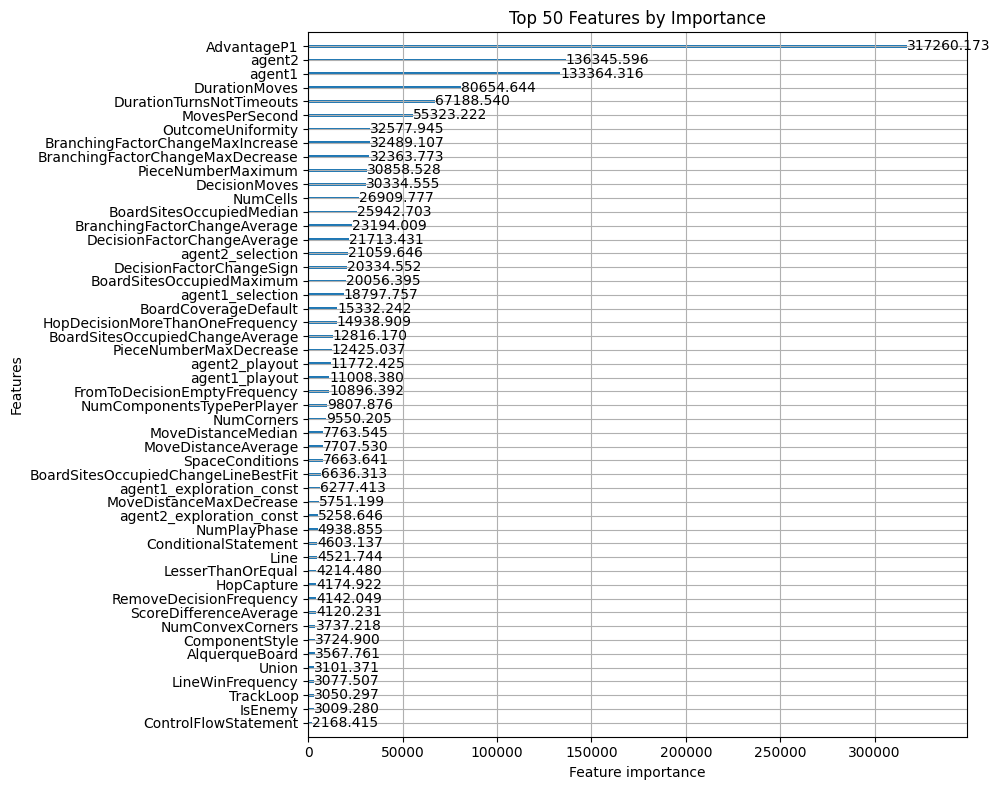

Fold 4 - RMSE: 0.4214946242427774
Fold 5


[100]	valid_0's rmse: 0.510099


[200]	valid_0's rmse: 0.487102


[300]	valid_0's rmse: 0.474035


[400]	valid_0's rmse: 0.466445


[500]	valid_0's rmse: 0.460821


[600]	valid_0's rmse: 0.456061


[700]	valid_0's rmse: 0.452649


[800]	valid_0's rmse: 0.449499


[900]	valid_0's rmse: 0.446714


[1000]	valid_0's rmse: 0.444115


[1100]	valid_0's rmse: 0.442485


[1200]	valid_0's rmse: 0.440689


[1300]	valid_0's rmse: 0.43941


[1400]	valid_0's rmse: 0.438142


[1500]	valid_0's rmse: 0.437114


[1600]	valid_0's rmse: 0.436179


[1700]	valid_0's rmse: 0.435293


[1800]	valid_0's rmse: 0.434343


[1900]	valid_0's rmse: 0.433707


[2000]	valid_0's rmse: 0.432934


[2100]	valid_0's rmse: 0.432312


[2200]	valid_0's rmse: 0.431795


[2300]	valid_0's rmse: 0.43129


[2400]	valid_0's rmse: 0.430873


[2500]	valid_0's rmse: 0.43036


[2600]	valid_0's rmse: 0.429907


[2700]	valid_0's rmse: 0.429498


[2800]	valid_0's rmse: 0.429125


[2900]	valid_0's rmse: 0.428685


[3000]	valid_0's rmse: 0.428376


[3100]	valid_0's rmse: 0.42806


[3200]	valid_0's rmse: 0.427842


[3300]	valid_0's rmse: 0.427591


[3400]	valid_0's rmse: 0.42726


[3500]	valid_0's rmse: 0.427013


[3600]	valid_0's rmse: 0.426836


[3700]	valid_0's rmse: 0.426601


[3800]	valid_0's rmse: 0.426372


[3900]	valid_0's rmse: 0.426131


[4000]	valid_0's rmse: 0.425815


[4100]	valid_0's rmse: 0.425786


[4200]	valid_0's rmse: 0.42563


[4300]	valid_0's rmse: 0.425497


[4400]	valid_0's rmse: 0.425313


[4500]	valid_0's rmse: 0.425161


[4600]	valid_0's rmse: 0.424992


[4700]	valid_0's rmse: 0.424803


[4800]	valid_0's rmse: 0.424659


[4900]	valid_0's rmse: 0.4245


[5000]	valid_0's rmse: 0.42438


[5100]	valid_0's rmse: 0.424278


[5200]	valid_0's rmse: 0.424205


[5300]	valid_0's rmse: 0.424129


[5400]	valid_0's rmse: 0.423924


[5500]	valid_0's rmse: 0.423763


[5600]	valid_0's rmse: 0.423683


[5700]	valid_0's rmse: 0.423621


[5800]	valid_0's rmse: 0.423536


[5900]	valid_0's rmse: 0.423468


[6000]	valid_0's rmse: 0.423412


[6100]	valid_0's rmse: 0.423351


[6200]	valid_0's rmse: 0.42326


[6300]	valid_0's rmse: 0.423111


[6400]	valid_0's rmse: 0.423096


[6500]	valid_0's rmse: 0.422976


[6600]	valid_0's rmse: 0.422925


[6700]	valid_0's rmse: 0.422862


[6800]	valid_0's rmse: 0.422864


[6900]	valid_0's rmse: 0.422793


[7000]	valid_0's rmse: 0.422675


[7100]	valid_0's rmse: 0.42263


[7200]	valid_0's rmse: 0.422592


[7300]	valid_0's rmse: 0.422531


[7400]	valid_0's rmse: 0.422438


[7500]	valid_0's rmse: 0.422392


[7600]	valid_0's rmse: 0.422273


[7700]	valid_0's rmse: 0.42223


[7800]	valid_0's rmse: 0.422256


[7900]	valid_0's rmse: 0.42217


[8000]	valid_0's rmse: 0.422177


[8100]	valid_0's rmse: 0.422145


[8200]	valid_0's rmse: 0.42212


[8300]	valid_0's rmse: 0.42205


[8400]	valid_0's rmse: 0.422001


[8500]	valid_0's rmse: 0.421989


[8600]	valid_0's rmse: 0.421997


[8700]	valid_0's rmse: 0.421982


[8800]	valid_0's rmse: 0.421893


[8900]	valid_0's rmse: 0.421879


[9000]	valid_0's rmse: 0.42187


[9100]	valid_0's rmse: 0.421816


[9200]	valid_0's rmse: 0.421713


[9300]	valid_0's rmse: 0.421654


[9400]	valid_0's rmse: 0.421676


[9500]	valid_0's rmse: 0.421639


[9600]	valid_0's rmse: 0.421592


[9700]	valid_0's rmse: 0.421619


[9800]	valid_0's rmse: 0.421601


[9900]	valid_0's rmse: 0.421619


[10000]	valid_0's rmse: 0.421618


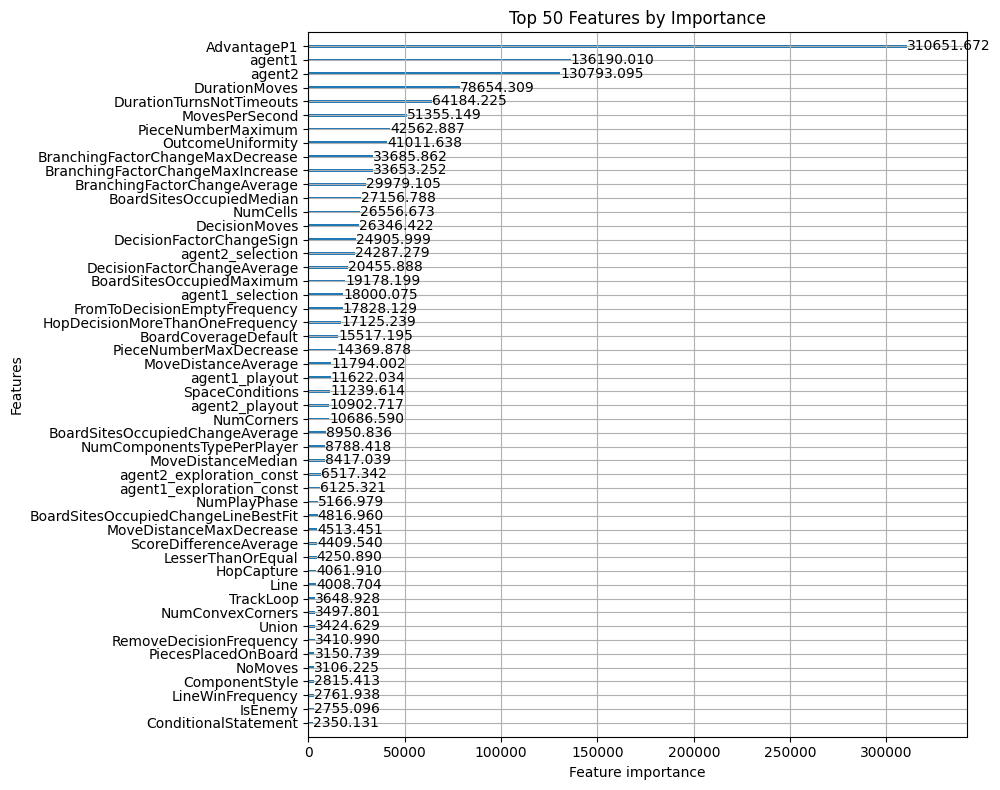

Fold 5 - RMSE: 0.42119146019535697
List of oof scores: [0.43494924748019653, 0.42731399051622676, 0.428900824071964, 0.4214946242427774, 0.42119146019535697]
Average oof score: 0.42677002930130425


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4402
Score: 0.4458
Score: 0.4307
Score: 0.4305
Score: 0.4068
Average CV1 Score: 0.4308

CV2 OOF Scores:
Score: 0.4207
Score: 0.4109
Score: 0.4339
Score: 0.4384
Score: 0.4299
Average CV2 Score: 0.4268

CV3 OOF Scores:
Score: 0.4349
Score: 0.4273
Score: 0.4289
Score: 0.4215
Score: 0.4212
Average CV3 Score: 0.4268


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

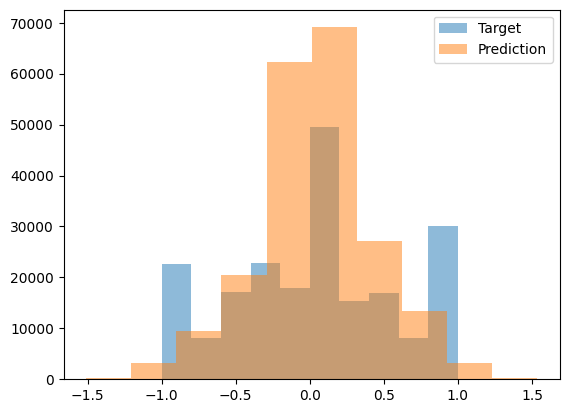

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.103198       │
│ 233235 ┆ -0.14114       │
│ 233236 ┆ -0.11076       │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./lightgbm_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***